## PATTERN RECOGNITION LAB3
## Αναγνώριση Είδους και Εξαγωγή Συναισθήματος από Μουσική
### ΑΝΔΡΕΑΣ ΚΟΝΤΟΓΙΑΝΝΗΣ (03115187)
### ΒΑΣΙΛΗΣ ΠΟΛΛΑΤΟΣ (03115011)
#### Kaggle: aponosiaponas


Σκοπό της παρακάτω εργαστηριακής άσκησης αποτελεί η αναγνώριση του είδους και η εξαγωγή συναισθηματικών διαστάσεων από spectrograms μουσικών κομματιών. Δίνονται 2 σύνολα δεδομένων, το Free Music Archive (FMA) genre με 3834 δείγματα χωρισμένα σε 20 κλάσεις και το multitask με 1497 δείγματα με labels συναισθηματικών διαστάσεων (valence, energy, danceability). Θα ασχοληθούμε με την ανάλυση των spectrograms μέσω Convolutional Neural Networks (CNN) και Long short-term Memory (LSTM).  
 

Καθόλη την διάρκεια της μελέτης μας, θα χρησιμοποιήσουμε τα παρακάτω modules.


In [0]:
import numpy as np
import pandas as pd
import librosa.display as display
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.externals import joblib

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Βήμα 1

In [0]:
# Spectrogram1
spec1 = np.load('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/20998.fused.full.npy')

# Spectrogram2
spec2 = np.load('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/1048.fused.full.npy')

In [0]:
# Sample Spectrogram shapes
print(spec1.shape)
print(spec2.shape)

(140, 1293)
(140, 1291)


In [0]:
# mel spectrogram + chromagram, timesteps
mel1, chroma1 = spec1[:128], spec1[128:]
mel2, chroma2 = spec2[:128], spec2[128:]

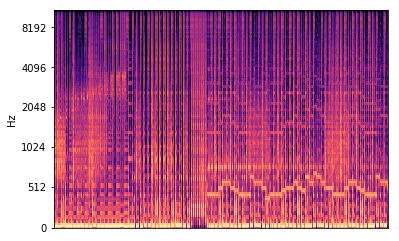

In [0]:
# label: international
display.specshow(mel1, y_axis='mel')

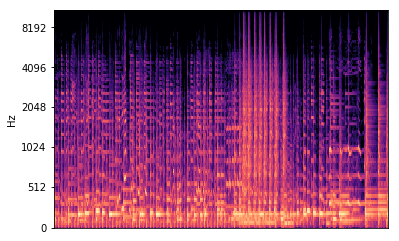

In [0]:
# label: blues
display.specshow(mel2, y_axis='mel')

## Βημα 2

In [0]:
# timesteps --> 2nd dimension
print(mel1.shape) 
print(mel2.shape)

(128, 1293)
(128, 1291)


Γενικά, υπάρχει πολύ μεγάλη καθυστέρηση στην εκτέλεση κάθε εποχής των recurrent networks (LSTM) λόγω του μεγέθους των ακολουθιών, που στην περίπτωση μας περιέχουν περιπού 1300 χρονικά βήματα. Έτσι, δεν ειναι τόσο αποδοτικό να φτιάξουμε LSTM, γιατί έχουμε πάρα πολλά timesteps και άρα θα αργήσει πάρα πολύ η εκπαίδευσή του. Για αυτό το λόγο πρέπει να τα μειώσουμε παίρνοντας την median ανάμεσα στα σημεία που χτυπάει το beat της μουσικής.

In [0]:
# Spectrogram1
spec1 = np.load('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/20998.fused.full.npy')

# Spectrogram2
spec2 = np.load('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/1048.fused.full.npy')

In [0]:
# Sample Spectrogram shapes
print(spec1.shape)
print(spec2.shape)

(140, 84)
(140, 50)


In [0]:
# mel spectrogram + chromagram, timesteps
mel1_beat, chroma1_beat = spec1[:128], spec1[128:]
mel2_beat, chroma2_beat = spec2[:128], spec2[128:]

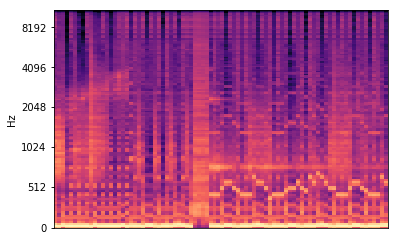

In [0]:
# label: international
display.specshow(mel1_beat, y_axis='mel')

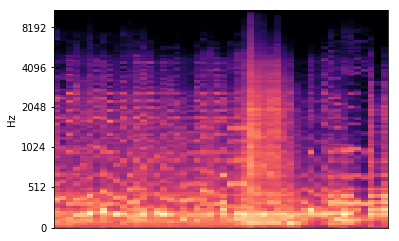

In [0]:
# label: blues
display.specshow(mel2_beat, y_axis='mel')

Μειώσαμε κατα πολύ τα timesteps, με αποτελέσμα να περιορίσουμε την ακρίβεια. Ωστόσο, ανάμεσα στα διαδοχικά beats έχουμε παρόμοιο συχνοτικό περιεχόμενο και άρα μια πυκνή απεικόνιση τους δεν προσφέρει κάποια σημαντική επιπλέον πληροφορία. Με αυτό τον τρόπο, μπορούμε να εκπαιδεύσουμε τα αναδρομικά δίκτυα πολύ πιο γρήγορα και ενδεχομένως το ίδιο ή/και πιο αποτελεσματικά.

## Βημα 3

In [0]:
# Chromograms, 12 musical notes
# timesteps --> 2nd dimension
print(chroma1.shape) 
print(chroma2.shape)

print(chroma1_beat.shape)
print(chroma2_beat.shape)

(12, 1293)
(12, 1291)
(12, 84)
(12, 50)


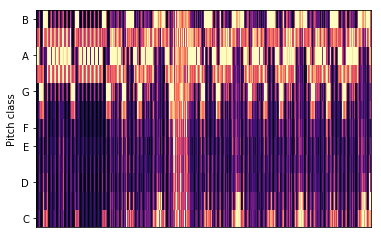

In [0]:
# label: international
display.specshow(chroma1, y_axis='chroma')

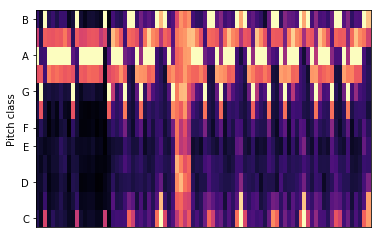

In [0]:
# label: international
display.specshow(chroma1_beat, y_axis='chroma')

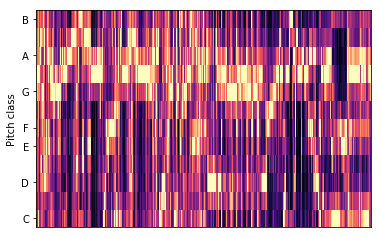

In [0]:
# label: blues
display.specshow(chroma2, y_axis='chroma')

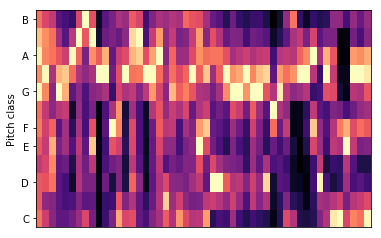

In [0]:
# label: blues
display.specshow(chroma2_beat, y_axis='chroma')

## Βημα 4

Παρακάτω, επιλέγουμε να συγχωνεύουμε κάποια είδη (κλάσεις) τραγουδιών, ενώ άλλα να τα αφαιρούμε. Αυτό αποσκοπεί στο γεγονός ότι υπάρχουν τέτοιες κλάσεις που εμφανίζονται σε δείγματα, τα οποία ωστόσο πιθανώς δεν έχουν πολλές ομοιότητες μεταξύ τους, με αποτέλεσμα να μην βοηθάει η ύπαρξή τους στο learning. Από την άλλη, αυτά που συγχωνεύτηκαν είτε εμφανίζουν πολλές ομοιότητες μεταξύ τους είτε η συγχώνευσή τους βοηθάει την γενικότερη επίδοση του learning.

In [0]:
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
import re

# Combine similar classes and remove underrepresented classes
class_mapping = {
    'Rock': 'Rock',
    'Psych-Rock': 'Rock',
    'Indie-Rock': None,
    'Post-Rock': 'Rock',
    'Psych-Folk': 'Folk',
    'Folk': 'Folk',
    'Metal': 'Metal',
    'Punk': 'Metal',
    'Post-Punk': None,
    'Trip-Hop': 'Trip-Hop',
    'Pop': 'Pop',
    'Electronic': 'Electronic',
    'Hip-Hop': 'Hip-Hop',
    'Classical': 'Classical',
    'Blues': 'Blues',
    'Chiptune': 'Electronic',
    'Jazz': 'Jazz',
    'Soundtrack': None,
    'International': None,
    'Old-Time': None
}


def torch_train_val_split(dataset, batch_train, batch_eval,
                            val_size=.2, shuffle=True, seed=None):
    # Uses seed and shuffling on dataset and produces a train loader and a validation loader 
    # with defining batch size
    
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    if shuffle:
        np.random.seed(seed)  
        np.random.shuffle(indices)  # kanw shuffle exontas arxikopoisei to seed, settarismeno sto debug prokeimenou na exw idio apotelesma
        # indices px [1,4,0,2,5 ...]
    
    train_indices = indices[val_split:]
    val_indices = indices[:val_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset,
                              batch_size=batch_train,
                              sampler=train_sampler)
    val_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=val_sampler)
    return train_loader, val_loader


def read_fused_spectrogram(spectrogram_file):
    '''
        spectrogram_file:  String, path file
    '''
    spectrogram = np.load(spectrogram_file)
    return spectrogram.T  # return (timesteps x freq)


def read_mel_spectrogram(spectrogram_file):
    '''
        spectrogram_file:  String, path file
    '''
    spectrogram = np.load(spectrogram_file)[:128]
    return spectrogram.T

    
def read_chromagram(spectrogram_file):
    '''
        spectrogram_file:  String, path file
    '''
    spectrogram = np.load(spectrogram_file)[128:]
    return spectrogram.T


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])


class PaddingTransform(object):
    # Padding when needed
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        '''
            s: numpy array
        '''
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[:self.max_length] 

        if len(s) < self.max_length:
            # Padding in order to have same numpy shapes for all samples
            # since their timesteps dimension differs 
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1

        
class SpectrogramDataset(Dataset):
    
    def __init__(self, path, class_mapping=None, train=True, max_length=-1, read_spec_fn=read_mel_spectrogram):
        '''
            path:            String, the filepath of our data
            class_mapping:   Dict, the mapping of kinds of music
            train:           Boolean, (training or testing)
            max_length:      int
            read_spec_fn     function, the way that we would like to use the data
        '''
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_labels(self.index, class_mapping)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(self.label_transformer.fit_transform(labels)).astype('int64')

            
    def get_files_labels(self, txt, class_mapping):
        # Returns a list of file names and a list of their labels
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            label = l[1]
            if class_mapping:
                label = class_mapping[l[1]]
            if not label:
                continue
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            _id = l[0].split('.')[0]
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            labels.append(label)
            
        return files, labels

    
    def __getitem__(self, item):
        # Returns padded item, item label, l
        l = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], l

    
    def __len__(self):
        # Returns the number of dataset samples
        return len(self.labels)


if __name__ == "__main__":
    ##################################################################################
    # load beat synced mel spectrograms
    ##################################################################################
    # Dataset
    beat_mel_specs = SpectrogramDataset('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/', train=True,
                                         class_mapping=class_mapping, max_length=-1,
                                         read_spec_fn=read_mel_spectrogram)
    # Train and Test loaders
    train_loader_beat_mel, val_loader_beat_mel = torch_train_val_split(beat_mel_specs, 32, 32, val_size=.33)
    test_dataset_beat_mel = SpectrogramDataset('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/', train=False,
                                                 class_mapping=class_mapping, max_length=-1,
                                                 read_spec_fn=read_mel_spectrogram)
    test_loader_beat_mel = DataLoader(test_dataset_beat_mel, batch_size=1)
    
    ##################################################################################
    # load beat synced chroma chromagrams
    ##################################################################################
    beat_chroma = SpectrogramDataset('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/', train=True,
                                     class_mapping=class_mapping, max_length=-1,
                                     read_spec_fn=read_chromagram)
    train_loader_beat_chroma, val_loader_beat_chroma = torch_train_val_split(beat_chroma, 32, 32, val_size=.33)
    test_dataset_beat_chroma = SpectrogramDataset('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/', train=False,
                                                 class_mapping=class_mapping, max_length=-1,
                                                 read_spec_fn=read_chromagram)
    test_loader_beat_chroma = DataLoader(test_dataset_beat_chroma, batch_size=1)

    ##################################################################################
    # load fused speectrogram + chromagram for the full (non-beat-synced) data
    ##################################################################################
    specs_fused = SpectrogramDataset('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', train=True,
                                     class_mapping=class_mapping, max_length=-1,
                                     read_spec_fn=read_fused_spectrogram)
    train_loader, val_loader = torch_train_val_split(specs_fused, 32, 32, val_size=.33)
    test_dataset = SpectrogramDataset('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', train=False,
                                     class_mapping=class_mapping, max_length=-1,
                                     read_spec_fn=read_fused_spectrogram)
    test_loader = DataLoader(test_dataset, batch_size=1)
    
    ##################################################################################
    # load single synced mel spectrograms
    ##################################################################################
    # Dataset
    mel_specs = SpectrogramDataset('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', train=True,
                                        class_mapping=class_mapping, max_length=-1,
                                        read_spec_fn=read_mel_spectrogram)
    # Train and Test loaders
    train_loader_mel, val_loader_mel = torch_train_val_split(mel_specs, 32, 32, val_size=.33)
    test_dataset_mel = SpectrogramDataset('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', train=False,
                                            class_mapping=class_mapping, max_length=-1,
                                            read_spec_fn=read_mel_spectrogram)
    
    test_loader_mel = DataLoader(test_dataset_mel, batch_size=1)


Με λίγα λόγια, το Dataset μας επιτρέπει να ορίσουμε εμείς το μέγεθος της ακολουθίας που τελικά θα χρησιμοποιήθει. Με αυτό τον τρόπο, μπορεί να έχουμε  cropping ή padding των ακολουθιών, ώστε τελικά να μπορούμε να τρέξουμε το νευρωνικό δίκτυο με batches. Στην μελέτη μας, επιλέγουμε να το ορίσουμε ως το μέγιστο μήκος της ακολουθίας.

Όταν κάνουμε πειράματα (debugging) με τα μοντέλα, δεν πρέπει να έχουμε καμία τυχαιότητα στην επιλογή των δύο dataset (ισοδύναμα seed=None). Αυτό συμβαίνει, διότι θέλουμε να ελέγχουμε την επίδοση διάφορων υπερπαραμέτρων (batch size, size of layers, etc) και αν επιτρέπουμε τυχαιότητα στο dataset, δεν θα είναι δυνατό να ερμηνεύσουμε βελτίωση στο accuracy, ως αποτέλεσμα fine tuning.

### Ιστογράμματα

#### Before Mapping

In [0]:
y_train = []
y_test = []

# Train labels
file1 = open('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train_labels.txt', 'r') 
Lines = file1.readlines()[1:] 
for line in Lines: 
    label = line.split()[1]
    y_train.append(label)
    
# Test labels
file1 = open('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/test_labels.txt', 'r') 
Lines = file1.readlines()[1:] 
for line in Lines: 
    label = line.split()[1]
    y_test.append(label)

print(np.unique(np.array(y_train)))
print(np.unique(np.array(y_test)))

['Blues' 'Chiptune' 'Classical' 'Electronic' 'Folk' 'Hip-Hop' 'Indie-Rock'
 'International' 'Jazz' 'Metal' 'Old-Time' 'Pop' 'Post-Punk' 'Post-Rock'
 'Psych-Folk' 'Psych-Rock' 'Punk' 'Rock' 'Soundtrack' 'Trip-Hop']
['Blues' 'Chiptune' 'Classical' 'Electronic' 'Folk' 'Hip-Hop' 'Indie-Rock'
 'International' 'Jazz' 'Metal' 'Old-Time' 'Pop' 'Post-Punk' 'Post-Rock'
 'Psych-Folk' 'Psych-Rock' 'Punk' 'Rock' 'Soundtrack' 'Trip-Hop']


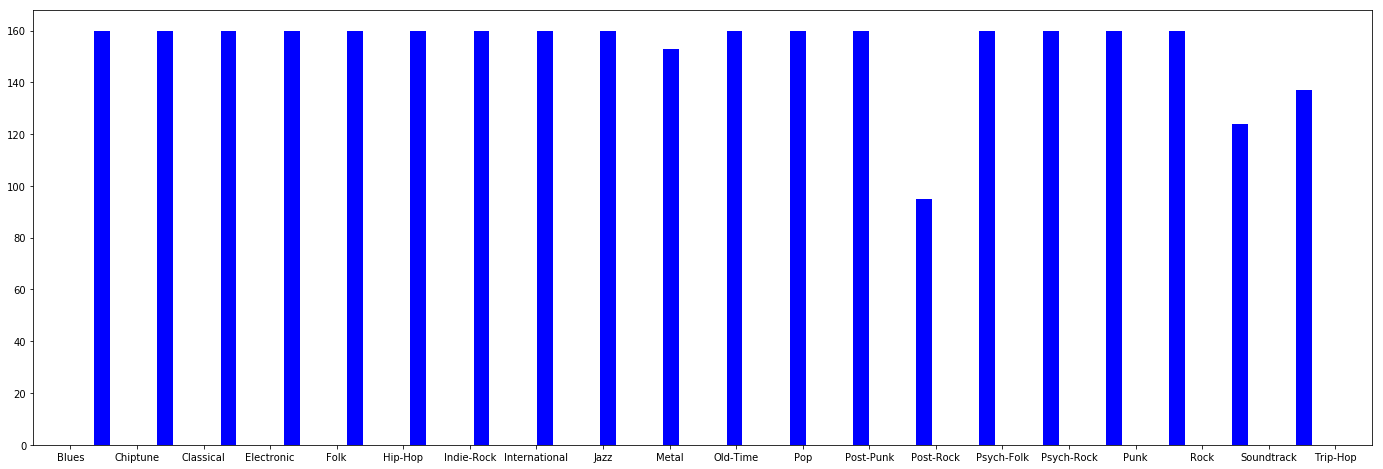

In [0]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# before mapping
num_bins = len(np.unique(y_train)) # 20
# train
plt.figure(figsize=(24,8))
n, bins, patches = plt.hist(y_train, bins=num_bins, facecolor='blue', rwidth=0.25)
plt.show()

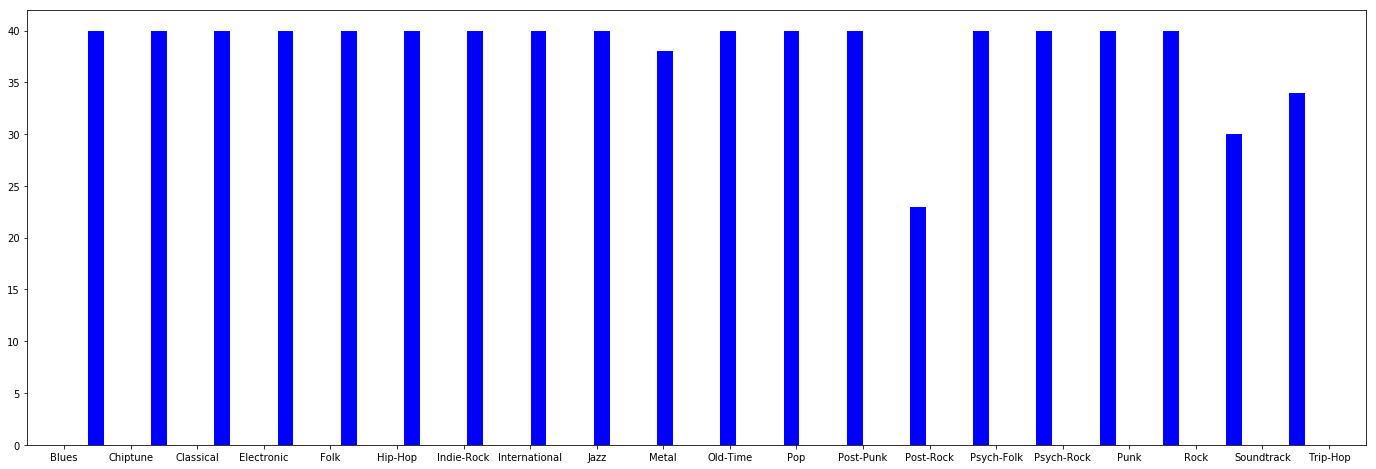

In [0]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# before mapping
num_bins = len(np.unique(y_test)) # 20
# test
plt.figure(figsize=(24,8))
n, bins, patches = plt.hist(y_test, bins=num_bins, facecolor='blue', rwidth=0.25)
plt.show()

#### After Mapping

In [0]:
y_train = []
y_test = []

# Train labels
file1 = open('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train_labels.txt', 'r') 
Lines = file1.readlines()[1:] 
for line in Lines: 
    label = line.split()[1]
    if class_mapping[label] is not None:
        y_train.append(class_mapping[label])
    
# Test labels
file1 = open('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/test_labels.txt', 'r') 
Lines = file1.readlines()[1:] 
for line in Lines: 
    label = line.split()[1]
    if class_mapping[label] is not None:
        y_test.append(class_mapping[label])

print(np.unique(np.array(y_train)))
print(np.unique(np.array(y_test)))

['Blues' 'Classical' 'Electronic' 'Folk' 'Hip-Hop' 'Jazz' 'Metal' 'Pop'
 'Rock' 'Trip-Hop']
['Blues' 'Classical' 'Electronic' 'Folk' 'Hip-Hop' 'Jazz' 'Metal' 'Pop'
 'Rock' 'Trip-Hop']


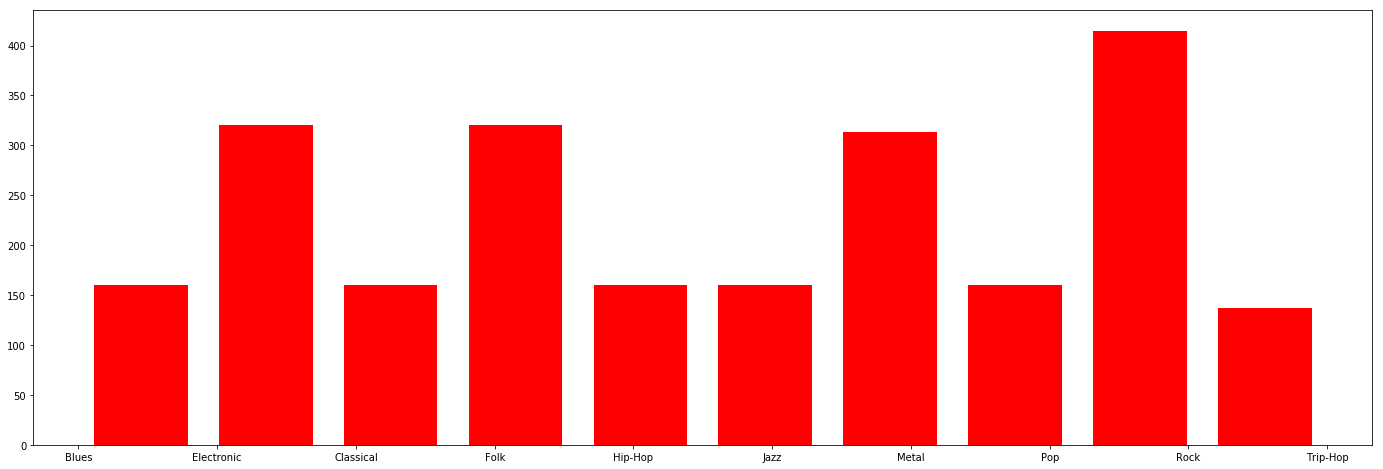

In [0]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# after mapping
num_bins = len(np.unique(y_train))
# train
plt.figure(figsize=(24,8))
n, bins, patches = plt.hist(y_train, bins=num_bins, facecolor='red', rwidth=0.75)
plt.show()

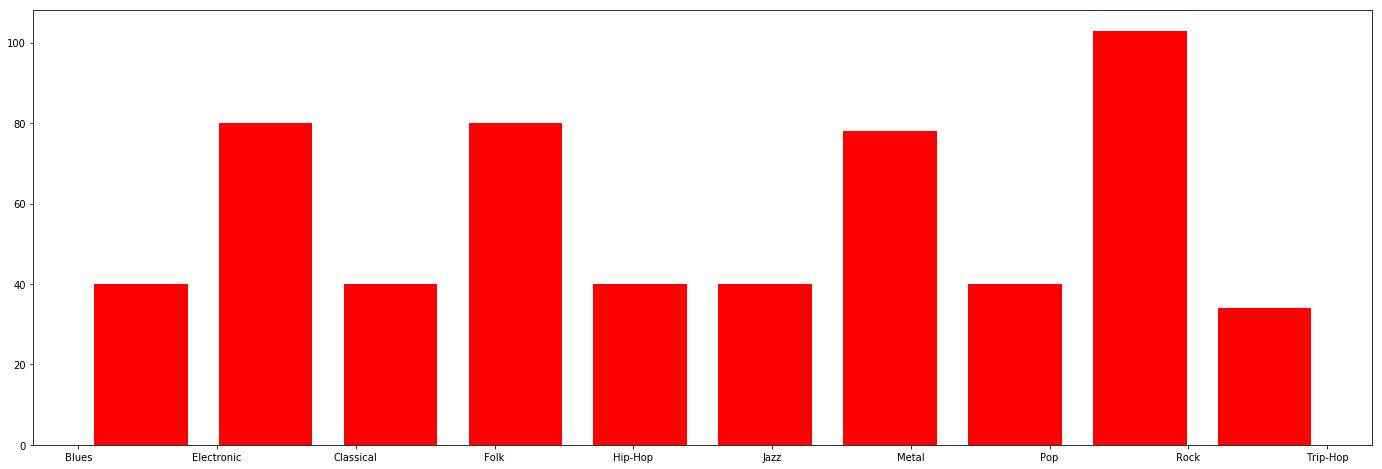

In [0]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# after mapping
num_bins = len(np.unique(y_test))
# test
plt.figure(figsize=(24,8))
n, bins, patches = plt.hist(y_test, bins=num_bins, facecolor='red', rwidth=0.75)
plt.show()

Παρατηρούμε πως μετά το mapping, τόσο το train όσο και το test έχουν την ίδια κατανομή ως προς τις συχνότητες των αντίστοιχων συγχωνευμένων και μη labels.

## Βημα 5, 6. LSTM

Στο σημείο αυτό, θα χρησιμοποιήσουμε το LSTM της προηγούμενης εργαστηριακής άσκησης για όλα τα δεδομένα dataset της εκφώνησης. Πιο αναλυτικά, το LSTM μας θα είναι bidirectional, με 2 layers, με rnn size ίσο με 100 και με χρήση dropout πιθανότητας ίσης με 0.1. Παρατηρούμε πως τα αποτελέσματα του testing είναι αρκετά ενθαρρυντικά, δεδομένης της δυσκολίας του προβλήματος και του μικρού όγκου δεδομένων. 

In [0]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from joblib import dump, load

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BasicLSTM(nn.Module):
    def __init__(self, input_dim, rnn_size, output_dim, num_layers, bidirectional=False):
        super(BasicLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size
        self.rnn_size = rnn_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, rnn_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(self.feature_size, output_dim)  

    nn.Dropout(0.1)
    def forward(self, x, lengths):
        x = x.float()
        # Set initial states
        bi = 2 if self.bidirectional else 1
        h0 = torch.zeros(self.num_layers*bi, x.size(0), self.rnn_size).to(device) 
        c0 = torch.zeros(self.num_layers*bi, x.size(0), self.rnn_size).to(device)
        
        # Forward propagate LSTM
        outputs, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, feature_size)
        
        # Decode the hidden state of the last time step
        outputs = self.fc(outputs[:, :, :])
        last_outputs = self.last_timestep(outputs, lengths, bidirectional=self.bidirectional)
          
        return last_outputs   
      
    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)

        else:
            return self.last_by_index(outputs, lengths)
        
    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1)
        return outputs.gather(1, idx).squeeze()


def train_LSTM(train_loader, val_loader, val_name, input_size, dataset):
    val_name += ".pkl"
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Hyper-parameters
    maxseqlen = -1
    input_size = input_size
    rnn_size = 100 
    num_layers = 2
    num_classes = 10
    num_epochs = 100
    learning_rate = 0.0001
    bidirectional = True

    maxseqlen = dataset.max_length
    print(maxseqlen)

    model = BasicLSTM(input_size, rnn_size, num_classes, num_layers, bidirectional=bidirectional).to(device)
    model = model.float()

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_loss = []
    vl = []
    tl = []
    min_val_loss = np.Inf
    n_epochs_stop = 10000000
    epochs_no_improve = 0
    best_val_loss = np.Inf
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        train_loss.append([])
        val_loss = 0
        early_stop = False


        for i, (feats, labels, lengths) in enumerate(val_loader):
            # Validation set
            feats_reshape = feats.reshape(-1, maxseqlen, input_size).to(device)
            labels = labels.to(device) 
            labels = torch.tensor(labels, dtype=torch.long, device=device)
            lengths = lengths.to(device)

            # Forward pass
            outputs = model(feats_reshape, lengths)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

        vl.append(val_loss / i)

        if val_loss <= best_val_loss:
            best_val_loss = val_loss
            joblib_file = val_name  
            joblib.dump(model, joblib_file)


        v_loss = 0
        for i, (feats, labels, lengths) in enumerate(train_loader):
            # Training set
            feats_reshape = feats.reshape(-1, maxseqlen, input_size).to(device)
            labels = labels.to(device) 
            labels = torch.tensor(labels, dtype=torch.long, device=device)
            lengths = lengths.to(device)

            # Forward pass
            outputs = model(feats_reshape, lengths)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i) % 4 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            train_loss[epoch].append(loss.item())

            # epoch loss
            v_loss += loss
            v_loss = v_loss / len(train_loader)

            # If the validation loss is at a minimum
            if v_loss < min_val_loss:

                #torch.save(model)
                epochs_no_improve = 0
                min_val_loss = v_loss

            else:
                epochs_no_improve += 1
            # Check early stopping condition           
            if epochs_no_improve == n_epochs_stop:
                print('Early stopping!' )
                early_stop = True
                break
            else:
                continue
            break
        if early_stop:
            print("Stopped")
            break
            
        tl.append(np.mean(train_loss[epoch]))

    # Tranform losses to numpy arrays
    tl=np.array(tl)
    vl=np.array(vl)
        
    # Plotting learning curve
    plt.figure()
    plt.plot(tl, label="training loss")
    plt.plot(vl, label="validation loss")
    plt.xlabel('epoch')
    plt.ylabel('mean loss in the epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()
    
    return maxseqlen
    
            
import warnings
warnings.simplefilter("ignore", UserWarning)

from sklearn.metrics import classification_report
def score_LSTM(test_loader, file_model, input_size, maxseqlen):
    # Estimating the model with classification report
    file_model += ".pkl"
    model = joblib.load(file_model)

    with torch.no_grad():
        correct = 0
        total = 0
        y_pred = []
        y_true = []
        for feats, labels, lengths in test_loader:
#             print(feats.shape)
            feats = feats.reshape(-1, maxseqlen, input_size).to(device)
#             print(feats.shape)
#             print(lengths.shape)
            labels = labels.to(device)
            labels = torch.tensor(labels, dtype=torch.long, device=device)
            lengths = lengths.to(device)
            outputs = model(feats, lengths).double()
            _, predicted = torch.max(outputs.data, 1)
            
            for pred in predicted:
                y_pred.append(pred.item())
            for label in labels:
                y_true.append(label.item())

        print(classification_report(y_true, y_pred))

### synced mel spectrograms

1293
Epoch [1/100], Step [1/49], Loss: 2.2984
Epoch [1/100], Step [5/49], Loss: 2.2898
Epoch [1/100], Step [9/49], Loss: 2.2862
Epoch [1/100], Step [13/49], Loss: 2.1991
Epoch [1/100], Step [17/49], Loss: 2.2869
Epoch [1/100], Step [21/49], Loss: 2.2993
Epoch [1/100], Step [25/49], Loss: 2.2214
Epoch [1/100], Step [29/49], Loss: 2.3110
Epoch [1/100], Step [33/49], Loss: 2.2647
Epoch [1/100], Step [37/49], Loss: 2.1862
Epoch [1/100], Step [41/49], Loss: 2.3038
Epoch [1/100], Step [45/49], Loss: 2.2727
Epoch [1/100], Step [49/49], Loss: 2.0961
Epoch [2/100], Step [1/49], Loss: 2.1415
Epoch [2/100], Step [5/49], Loss: 2.1887
Epoch [2/100], Step [9/49], Loss: 2.2193
Epoch [2/100], Step [13/49], Loss: 2.2788
Epoch [2/100], Step [17/49], Loss: 2.2075
Epoch [2/100], Step [21/49], Loss: 2.1795
Epoch [2/100], Step [25/49], Loss: 2.2149
Epoch [2/100], Step [29/49], Loss: 2.0750
Epoch [2/100], Step [33/49], Loss: 2.1500
Epoch [2/100], Step [37/49], Loss: 2.1459
Epoch [2/100], Step [41/49], Loss: 

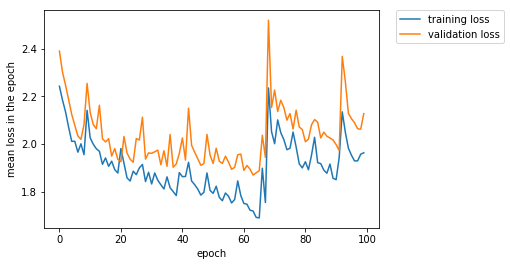

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.45      0.62      0.52        40
           2       0.38      0.60      0.46        80
           3       0.34      0.55      0.42        80
           4       0.29      0.10      0.15        40
           5       0.33      0.05      0.09        40
           6       0.48      0.38      0.43        78
           7       0.33      0.03      0.05        40
           8       0.33      0.40      0.36       103
           9       0.13      0.18      0.15        34

    accuracy                           0.35       575
   macro avg       0.31      0.29      0.26       575
weighted avg       0.33      0.35      0.31       575



In [0]:
maxseqlen = train_LSTM(train_loader_mel, val_loader_mel, "lstm_single_mel", input_size=128, dataset=mel_specs)
score_LSTM(test_loader_mel, "lstm_single_mel", input_size=128, maxseqlen=maxseqlen)

### beat synced mel spectrograms

129
Epoch [1/100], Step [1/49], Loss: 2.3016
Epoch [1/100], Step [5/49], Loss: 2.2489
Epoch [1/100], Step [9/49], Loss: 2.2580
Epoch [1/100], Step [13/49], Loss: 2.2345
Epoch [1/100], Step [17/49], Loss: 2.2984
Epoch [1/100], Step [21/49], Loss: 2.1905
Epoch [1/100], Step [25/49], Loss: 2.2699
Epoch [1/100], Step [29/49], Loss: 2.1800
Epoch [1/100], Step [33/49], Loss: 2.2411
Epoch [1/100], Step [37/49], Loss: 2.2272
Epoch [1/100], Step [41/49], Loss: 2.2521
Epoch [1/100], Step [45/49], Loss: 2.2166
Epoch [1/100], Step [49/49], Loss: 2.2164
Epoch [2/100], Step [1/49], Loss: 2.2279
Epoch [2/100], Step [5/49], Loss: 2.1687
Epoch [2/100], Step [9/49], Loss: 2.2572
Epoch [2/100], Step [13/49], Loss: 2.2125
Epoch [2/100], Step [17/49], Loss: 2.1732
Epoch [2/100], Step [21/49], Loss: 2.2576
Epoch [2/100], Step [25/49], Loss: 2.2099
Epoch [2/100], Step [29/49], Loss: 2.1850
Epoch [2/100], Step [33/49], Loss: 2.1268
Epoch [2/100], Step [37/49], Loss: 2.2739
Epoch [2/100], Step [41/49], Loss: 2

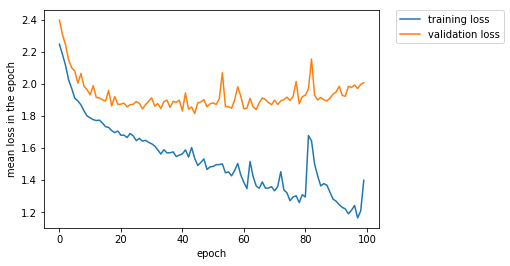

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.38      0.62      0.48        40
           2       0.38      0.64      0.47        80
           3       0.40      0.47      0.44        80
           4       0.27      0.23      0.25        40
           5       0.05      0.03      0.03        40
           6       0.63      0.41      0.50        78
           7       0.00      0.00      0.00        40
           8       0.37      0.47      0.41       103
           9       0.19      0.15      0.16        34

    accuracy                           0.36       575
   macro avg       0.27      0.30      0.27       575
weighted avg       0.32      0.36      0.33       575



In [0]:
maxseqlen = train_LSTM(train_loader_beat_mel, val_loader_beat_mel, "lstm_beat_mel", input_size=128, dataset=beat_mel_specs)
score_LSTM(test_loader_beat_mel, "lstm_beat_mel", input_size=128, maxseqlen=test_dataset_beat_mel.max_length)

### beat synced chromograms

129
Epoch [1/100], Step [1/49], Loss: 2.3103
Epoch [1/100], Step [5/49], Loss: 2.3066
Epoch [1/100], Step [9/49], Loss: 2.2944
Epoch [1/100], Step [13/49], Loss: 2.3002
Epoch [1/100], Step [17/49], Loss: 2.3013
Epoch [1/100], Step [21/49], Loss: 2.2877
Epoch [1/100], Step [25/49], Loss: 2.2940
Epoch [1/100], Step [29/49], Loss: 2.2862
Epoch [1/100], Step [33/49], Loss: 2.2823
Epoch [1/100], Step [37/49], Loss: 2.2636
Epoch [1/100], Step [41/49], Loss: 2.2746
Epoch [1/100], Step [45/49], Loss: 2.2777
Epoch [1/100], Step [49/49], Loss: 2.2674
Epoch [2/100], Step [1/49], Loss: 2.2973
Epoch [2/100], Step [5/49], Loss: 2.2647
Epoch [2/100], Step [9/49], Loss: 2.2884
Epoch [2/100], Step [13/49], Loss: 2.2364
Epoch [2/100], Step [17/49], Loss: 2.2702
Epoch [2/100], Step [21/49], Loss: 2.2833
Epoch [2/100], Step [25/49], Loss: 2.2465
Epoch [2/100], Step [29/49], Loss: 2.2408
Epoch [2/100], Step [33/49], Loss: 2.2280
Epoch [2/100], Step [37/49], Loss: 2.2496
Epoch [2/100], Step [41/49], Loss: 2

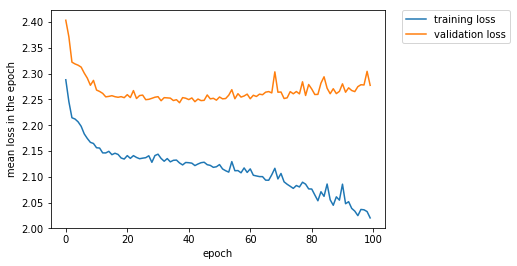

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00        80
           3       0.22      0.64      0.33        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.33      0.42      0.37        78
           7       0.00      0.00      0.00        40
           8       0.19      0.44      0.26       103
           9       0.00      0.00      0.00        34

    accuracy                           0.22       575
   macro avg       0.07      0.15      0.10       575
weighted avg       0.11      0.22      0.14       575



In [0]:
maxseqlen = train_LSTM(train_loader_beat_chroma, val_loader_beat_chroma, "lstm_beat_chroma", input_size=12, dataset=beat_chroma)
score_LSTM(test_loader_beat_chroma, "lstm_beat_chroma", input_size=12, maxseqlen=test_dataset_beat_chroma.max_length)

### beat-fused synced 

1293
Epoch [1/100], Step [1/49], Loss: 2.3160
Epoch [1/100], Step [5/49], Loss: 2.3221
Epoch [1/100], Step [9/49], Loss: 2.2851
Epoch [1/100], Step [13/49], Loss: 2.2950
Epoch [1/100], Step [17/49], Loss: 2.2323
Epoch [1/100], Step [21/49], Loss: 2.2687
Epoch [1/100], Step [25/49], Loss: 2.2305
Epoch [1/100], Step [29/49], Loss: 2.2530
Epoch [1/100], Step [33/49], Loss: 2.3022
Epoch [1/100], Step [37/49], Loss: 2.2652
Epoch [1/100], Step [41/49], Loss: 2.1509
Epoch [1/100], Step [45/49], Loss: 2.2679
Epoch [1/100], Step [49/49], Loss: 2.2001
Epoch [2/100], Step [1/49], Loss: 2.1500
Epoch [2/100], Step [5/49], Loss: 2.1797
Epoch [2/100], Step [9/49], Loss: 2.2546
Epoch [2/100], Step [13/49], Loss: 2.2286
Epoch [2/100], Step [17/49], Loss: 2.1593
Epoch [2/100], Step [21/49], Loss: 2.1900
Epoch [2/100], Step [25/49], Loss: 2.2519
Epoch [2/100], Step [29/49], Loss: 2.2705
Epoch [2/100], Step [33/49], Loss: 2.1318
Epoch [2/100], Step [37/49], Loss: 2.1775
Epoch [2/100], Step [41/49], Loss: 

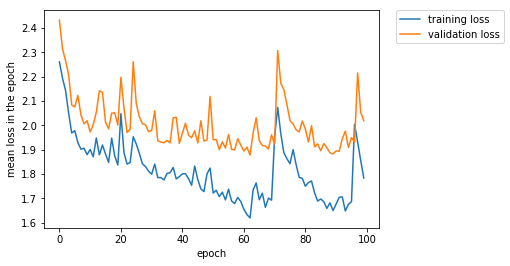

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.38      0.60      0.47        40
           2       0.36      0.54      0.43        80
           3       0.35      0.61      0.44        80
           4       0.24      0.23      0.23        40
           5       0.00      0.00      0.00        40
           6       0.44      0.45      0.44        78
           7       0.00      0.00      0.00        40
           8       0.36      0.29      0.32       103
           9       0.16      0.21      0.18        34

    accuracy                           0.34       575
   macro avg       0.23      0.29      0.25       575
weighted avg       0.27      0.34      0.30       575



In [0]:
maxseqlen = train_LSTM(train_loader, val_loader, "lstm_beat_fused", input_size=140, dataset=specs_fused)
score_LSTM(test_loader, "lstm_beat_fused", input_size=140, maxseqlen=test_dataset.max_length)

Στο σημείο αυτό θα εξετάσουμε τις μετρικές που λάβαμε υπόψιν στον classification report.  

1. Accuracy: εκφράζει το συνολικό ποσοστό των δειγμάτων που ταξινομήθηκαν σε σωστή κλάση και είναι πολύ άμεσος και αποτελεσματικός τρόπος να εκτιμήσουμε την επίδοση ενός μοντέλου.   

2. Precision: αναφέρεται σε μια μεμονωμένη κλάση C και ισούται με το λόγο tp / (tp + fp) όπου tp (true positive) είναι ο αριθμός των δειγμάτων που ταξινομήθηκαν ορθώς σε αυτή την κλάση και fp (false positive) ο αριθμός των δειγμάτων που ταξινομήθηκαν λανθασμένα σε αυτή την κλάση. Διαισθητικά αξιολογεί την ικανότητα του μοντέλου να διακρίνει άσχετα δείγματα από τη δεδομένη κλάση.  


3. Recall: αναφέρεται σε μια μεμονωμένη κλάση C και ισούται με το λόγο tp / (tp + fn) όπου fn (false negative) ο αριθμός των δειγμάτων που ανήκουν στην κλάση C αλλά ταξινομήθηκαν σε άλλη. Διαισθητικά,  αξιολογεί την ικανότητα του μοντέλου να διακρίνει την δεδομένη κλάση μέσα στα δείγματα.   

4. F1-score: σταθμισμένος αρμονικός μέσος όρος των precision και recall για μια κλάση, δίνοντας έτσι μια γενική αξιολόγηση του μοντέλου για μια συγκεκριμένη κλάση.  

5. Macro: επιστρέφουν το μέσο όρο των αποτελεσμάτων, συνεπώς αντιμετωπίζουν ισότιμα κάθε κλάση και δεν λαμβάνουν υπόψιν το ενδεχόμενο του imbalanced dataset.   

6. Micro:  συγκεντρώνουν τα tp, fp και fn για όλες τις κλάσεις και υπολογίζουν ενοποιημένα την μέση μετρική. Έτσι, λαμβάνουν υπόψη το class imbalance, και αυτή είναι και η πιο συχνή αιτία όταν αποκλίνουν τα micro-macro.

Έτσι, μας βολεύει το micro average να λάβουμε υπόψιν, καθώς και το accuracy. 

Γενικώς, μεγάλη διαφορά ανάμεσα στα accuracy και F1 προκύπτει, όταν το μοντέλο τείνει να επικεντρώνεται σε μια, ή/και δύο κλάσεις αν έχουμε πολλές, εξαιτίας πιθανού imbalanced dataset ή underfitting. Με αυτό τον τρόπο, το accuracy θα επηρεάζεται μόνο από το μέγεθος των samples αυτής της μεγάλης κλάσης και δεν θα λαμβάνει σε μεγάλο βαθμό υπόψιν τις υπόλοιπες. 

Τα precision και recall έχουν μεγάλη ισχύ σε περιπτώσεις που τα false positives/negatives έχουν σημαντικές συνέπειες στην μελέτη, πχ. στην διάγνωση καρκίνου.    






Στην μελέτη μας, παρατηρούμε πως τα spectrograms ταξινομούνται αποτελεσματικότερα από τα chromograms. Το ίδιο συμβαίνει και με τα fused που ταξινομούνται σχεδόν οπως τα spectrograms. Βλέπουμε πως στα chromograms, το LSTM δεν καταφέρνει να εντοπίσει στο classification αρκετές κλάσεις, εξού και το χαμηλό αποτέλεσμα των μετρικών του. 

## Βήμα 7. CNN

### MNIST

To screenshot παρέχεται και στο .zip αρχείο.

<img src="./mnist.png">

Το δίκτυο αρχικά φαίνεται να βρίσκει προσανατολισμένα περιγράμματα και  ακμές (αριστερές, δεξιές, πάνω, κάτω όψεις). Στο δεύτερο επίπεδο, το δίκτυο βρίσκει αποκλειστικά ακμές. Τα επόμενα επίπεδα χάνουν τη σημασιολογία τους για τον άνθρωπο και έχουν πολύ μικρή ανάλυση για οπτικοποίηση.

### Convolutional NN

Όμοια με παραπάνω, θα χρησιμοποιήσουμε ίδια λογική για το dataset, με τη διαφορά ότι τώρα θα πάρουμε μόνο το fma_genre_spectrograms dataset. 

In [0]:
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
import re

# Combine similar classes and remove underrepresented classes
class_mapping = {
    'Rock': 'Rock',
    'Psych-Rock': 'Rock',
    'Indie-Rock': None,
    'Post-Rock': 'Rock',
    'Psych-Folk': 'Folk',
    'Folk': 'Folk',
    'Metal': 'Metal',
    'Punk': 'Metal',
    'Post-Punk': None,
    'Trip-Hop': 'Trip-Hop',
    'Pop': 'Pop',
    'Electronic': 'Electronic',
    'Hip-Hop': 'Hip-Hop',
    'Classical': 'Classical',
    'Blues': 'Blues',
    'Chiptune': 'Electronic',
    'Jazz': 'Jazz',
    'Soundtrack': None,
    'International': None,
    'Old-Time': None
}

def torch_train_val_split(dataset, batch_train, batch_eval,
                            val_size=.2, shuffle=True, seed=None):
    # Uses seed and shuffling on dataset and produces a train loader and a validation loader 
    # with defining batch size
    
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    if shuffle:
        np.random.seed(seed)  
        np.random.shuffle(indices)  # kanw shuffle exontas arxikopoisei to seed, settarismeno sto debug prokeimenou na exw idio apotelesma
        # indices px [1,4,0,2,5 ...]
    
    train_indices = indices[val_split:]
    val_indices = indices[:val_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset,
                              batch_size=batch_train,
                              sampler=train_sampler)
    val_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=val_sampler)
    return train_loader, val_loader


def read_fused_spectrogram(spectrogram_file):
    '''
        spectrogram_file:  String, path file
    '''
    spectrogram = np.load(spectrogram_file)
    return spectrogram.T  # return (timesteps x freq)


def read_mel_spectrogram(spectrogram_file):
    '''
        spectrogram_file:  String, path file
    '''
    spectrogram = np.load(spectrogram_file)[:128]
    return spectrogram.T

    
def read_chromagram(spectrogram_file):
    '''
        spectrogram_file:  String, path file
    '''
    spectrogram = np.load(spectrogram_file)[128:]
    return spectrogram.T


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])


class PaddingTransform(object):
    # Padding when needed
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        '''
            s: numpy array
        '''
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[:self.max_length] 

        if len(s) < self.max_length:
            # Padding in order to have same numpy shapes for all samples
            # since their timesteps dimension differs 
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1

        
class SpectrogramDataset(Dataset):
    
    def __init__(self, path, class_mapping=None, train=True, max_length=-1, read_spec_fn=read_mel_spectrogram):
        '''
            path:            String, the filepath of our data
            class_mapping:   Dict, the mapping of kinds of music
            train:           Boolean, (training or testing)
            max_length:      int
            read_spec_fn     function, the way that we would like to use the data
        '''
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_labels(self.index, class_mapping)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(self.label_transformer.fit_transform(labels)).astype('int64')

            
    def get_files_labels(self, txt, class_mapping):
        # Returns a list of file names and a list of their labels
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            label = l[1]
            if class_mapping:
                label = class_mapping[l[1]]
            if label is None:
                continue
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            _id = l[0].split('.')[0]
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            labels.append(label)
            
        return files, labels

    
    def __getitem__(self, item):
        # Returns padded item, item label, l
        l = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], l

    
    def __len__(self):
        # Returns the number of dataset samples
        return len(self.labels)


if __name__ == "__main__":
    
    ##################################################################################
    # load single synced mel spectrograms
    ##################################################################################
    # Dataset
    mel_specs = SpectrogramDataset('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', train=True,
                                        class_mapping=class_mapping, max_length=-1,
                                        read_spec_fn=read_mel_spectrogram)
    # Train and Test loaders
    train_loader_mel, val_loader_mel = torch_train_val_split(mel_specs, 32, 32, val_size=.33)
    test_dataset_mel = SpectrogramDataset('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', train=False,
                                            class_mapping=class_mapping, max_length=-1,
                                            read_spec_fn=read_mel_spectrogram)
    
    test_loader_mel = DataLoader(test_dataset_mel, batch_size=1)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class CNN(nn.Module):

    def __init__(self):
    
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        )    
        self.layer2 = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),    
            
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=5),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        )
        self.layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        )
        self.fc1 = nn.Linear(19712*4, 10)
        
        
        
        
    def forward(self, x):
        # Forward function of CNN
        
        out = self.layer1(x)     # conv1
        out = self.layer2(out)   # conv2
        out = self.layer3(out)   # conv3
        out = self.layer4(out)   # conv4
        out = out.view(out.size(0), -1)
        out = nn.Dropout2d(p=0.28)(out) # dropout
        out = self.fc1(out)      # fully-connected1
        return out


def train_CNN(train_loader, val_loader, val_name, mels, dataset):
    '''
        train_loader:  Dataloader
        val_loader:    Dataloader
        val_name:      String
        mels:          int, input size
        dataset:       SpectrumDataset
    '''
    
    val_name += ".pkl"
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Hyper-parameters
    num_classes = 10
    num_epochs = 50
    learning_rate = 0.0001
    momentum = 0
    
    maxseqlen = dataset.max_length

    model = CNN().to(device)
    model = model.double()

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    # Train the model
    train_loss = []
    vl = []
    tl = []
    min_val_loss = np.Inf
    n_epochs_stop = 10000000
    epochs_no_improve = 0
    best_val_loss = np.Inf
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        train_loss.append([])
        val_loss = 0
        early_stop = False


        for i, (feats, labels, lengths) in enumerate(val_loader):
            # Validation set
            feats_reshape = feats.reshape(-1, 1, maxseqlen, mels).to(device)
            labels = labels.to(device) 
            labels = torch.tensor(labels, dtype=torch.long, device=device)
            lengths = lengths.to(device)

            # Forward pass
            outputs = model.forward(feats_reshape)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

        vl.append(val_loss / i)
        print("Validation loss:\t", val_loss)
        
        if val_loss <= best_val_loss:
            # Keep the model with minimum validation loss
            best_val_loss = val_loss
            joblib_file = val_name  
            joblib.dump(model, joblib_file)

        v_loss = 0
        for i, (feats, labels, lengths) in enumerate(train_loader):
            # Training set
            feats_reshape = feats.reshape(-1, 1, maxseqlen, mels).to(device)
            labels = labels.to(device) 
            labels = torch.tensor(labels, dtype=torch.long, device=device)
            lengths = lengths.to(device)

            # Forward pass
            outputs = model.forward(feats_reshape)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i) % 4 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            train_loss[epoch].append(loss.item())

            # epoch loss
            v_loss += loss
            v_loss = v_loss / len(train_loader)

            # If the validation loss is at a minimum
            if v_loss < min_val_loss:

                #torch.save(model)
                epochs_no_improve = 0
                min_val_loss = v_loss

            else:
                epochs_no_improve += 1
            # Check early stopping condition           
            if epochs_no_improve == n_epochs_stop:
                print('Early stopping!' )
                early_stop = True
                break
            else:
                continue
            break
        if early_stop:
            print("Stopped")
            break
            
        tl.append(np.mean(train_loss[epoch]))

    # Tranform losses to numpy arrays
    tl=np.array(tl)
    vl=np.array(vl)
        
    # Plotting learning curve
    plt.figure()
    plt.plot(tl, label="training loss")
    plt.plot(vl, label="validation loss")
    plt.xlabel('epoch')
    plt.ylabel('mean loss in the epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()
    
    return maxseqlen
    
            
import warnings
warnings.simplefilter("ignore", UserWarning)

from sklearn.metrics import classification_report
def score_CNN(test_loader, file_model, mels, maxseqlen):
    # Estimating the model with classification report
    '''
        test_loader:   Dataloader
        file_model:    String, filepath of best model
        mels:          int, input size
        maxseqlen:     int
    '''
        
    file_model += ".pkl"
    model = joblib.load(file_model)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Disable batch normalization and dropout in testing
    model.eval()
    
    with torch.no_grad():
        correct = 0
        total = 0
        y_pred = []
        y_true = []
        for feats, labels, lengths in test_loader:
            feats = feats.reshape(-1, 1, maxseqlen, mels).to(device)
            labels = labels.to(device)
            labels = torch.tensor(labels, dtype=torch.long, device=device)
            outputs = model.forward(feats).double()
            _, predicted = torch.max(outputs.data, -1)
            y_pred.append(predicted.item())
            y_true.append(labels.item())

        print(classification_report(y_true, y_pred))

Validation loss:	 63.5076498635987
Epoch [1/50], Step [1/49], Loss: 2.7471
Epoch [1/50], Step [5/49], Loss: 2.4395
Epoch [1/50], Step [9/49], Loss: 2.3369
Epoch [1/50], Step [13/49], Loss: 2.2404
Epoch [1/50], Step [17/49], Loss: 2.1593
Epoch [1/50], Step [21/49], Loss: 2.3323
Epoch [1/50], Step [25/49], Loss: 2.0074
Epoch [1/50], Step [29/49], Loss: 2.1787
Epoch [1/50], Step [33/49], Loss: 2.0195
Epoch [1/50], Step [37/49], Loss: 2.2525
Epoch [1/50], Step [41/49], Loss: 2.1601
Epoch [1/50], Step [45/49], Loss: 1.9969
Epoch [1/50], Step [49/49], Loss: 2.1518
Validation loss:	 57.56088943499755
Epoch [2/50], Step [1/49], Loss: 2.4159
Epoch [2/50], Step [5/49], Loss: 2.2549
Epoch [2/50], Step [9/49], Loss: 1.9848
Epoch [2/50], Step [13/49], Loss: 2.1280
Epoch [2/50], Step [17/49], Loss: 2.0748
Epoch [2/50], Step [21/49], Loss: 1.6829
Epoch [2/50], Step [25/49], Loss: 1.9419
Epoch [2/50], Step [29/49], Loss: 1.9690
Epoch [2/50], Step [33/49], Loss: 1.7793
Epoch [2/50], Step [37/49], Loss:

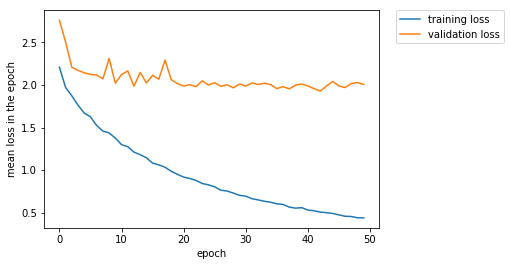

In [0]:
maxseqlen = train_CNN(train_loader_mel, val_loader_mel, "cnn_single_mel", mels=128, dataset=mel_specs)

In [0]:
score_CNN(test_loader_mel, "cnn_single_mel", mels=128, maxseqlen=maxseqlen)

              precision    recall  f1-score   support

           0       0.09      0.03      0.04        40
           1       0.51      0.47      0.49        40
           2       0.35      0.57      0.44        80
           3       0.38      0.59      0.46        80
           4       0.38      0.38      0.38        40
           5       0.16      0.15      0.16        40
           6       0.48      0.41      0.44        78
           7       0.00      0.00      0.00        40
           8       0.37      0.36      0.37       103
           9       0.31      0.15      0.20        34

    accuracy                           0.36       575
   macro avg       0.30      0.31      0.30       575
weighted avg       0.33      0.36      0.34       575



Σε αυτό το σημείο, μπορούμε να εστιάσουμε σε κάποια θεωρητικά σημεία του παραπάνω δικτύου.  

Οι **συνελίξεις** αποτελούν ουσιαστικά φίλτρα εικόνων, όσων αφορά δυσδιάστατες ποσότητες. Στα νευρωνικά δίκτυα γίνεται χρήση τους διοτί περιορίζουν το πλήθος των παραμέτρων και δίνεται η δυνατότητα της εύρεσης ενός χαρακτηριστικού σε όλη την εικόνα. 

Το **max pooling** είναι αρκετά όμοιο με τη συνέλιξη, με τη διαφορά πως δεν βρίσκει γραμμικό συνδυασμό της εικόνας, αλλά κρατάει το μεγαλύτερο χαρακτηριστικό. Με αυτόν τον τρόπο μειώνεται η διαστατικότητα των παραμέτρων, ελέγχοντας έτσι και το overfitting. 

Η **ReLU** είναι μη-γραμμική συνάρτηση, η οποία επιτρέπει την μοντελοποιήση μη-γραμμικών εξαρτήσεων μεταξύ των data. Είναι μία από τις πιο δημοφιλείς συναρτήσεις που χρησιμοποιούνται στα νευρωνικά δίκτυα.

Το **batch normalization** είναι πολύ χρήσιμο στα νευρωνικά δίκτυα. Έχει ως αποτέλεσμα να μην υπάρχουν μεγάλες μεταβολές στις τιμές που δέχονται τα ενδιάμεσα επίπεδα ενός δικτύου, επιτρέποντας μεγαλύτερο learning rate. Επιπλέον, επιφέρει το reguralization του μοντέλου μέσα από την κανονικοποίηση του batch που κάθε φορά το δίκτυο δέχεται στην είσοδο κάθε επιπέδου, που εφαρμόζεται αυτή η τεχνική.

## Βήμα 8. Regression


Στο βήμα αυτό, εισαγάγουμε την μεταβλητή kind, που αντιστοιχεί σε τρεις πιθανές τιμές: 0 για valence, 1 για energy και 2 για danceability. Θα δοκιμάσουμε πάνω στο multitask dataset και το LSTM και το CNN, προκειμένου να τα εκπαιδεύσουμε για regression πάνω στα παραπάνω τρια μουσικά χαρακτηριστικά.

### LSTM

In [0]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from joblib import dump, load

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BasicLSTM(nn.Module):
    def __init__(self, input_dim, rnn_size, output_dim, num_layers, bidirectional=False):
        super(BasicLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size
        self.rnn_size = rnn_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, rnn_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(self.feature_size, output_dim)  

    nn.Dropout(0.1)
    def forward(self, x, lengths):
        x = x.float()
        # Set initial states
        bi = 2 if self.bidirectional else 1
        h0 = torch.zeros(self.num_layers*bi, x.size(0), self.rnn_size).to(device) 
        c0 = torch.zeros(self.num_layers*bi, x.size(0), self.rnn_size).to(device)
        
        # Forward propagate LSTM
        outputs, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, feature_size)
        
        # Decode the hidden state of the last time step
        outputs = self.fc(outputs[:, :, :])
        last_outputs = self.last_timestep(outputs, lengths, bidirectional=self.bidirectional)
          
        return last_outputs   
      
    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)

        else:
            return self.last_by_index(outputs, lengths)
        
    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1)
        return outputs.gather(1, idx).squeeze()


def train_LSTM(train_loader, val_loader, val_name, input_size, dataset, kind):
    val_name += ".pkl"
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Hyper-parameters
    maxseqlen = -1
    input_size = input_size
    rnn_size = 100 #128
    num_layers = 2
    out_dim = 1
    num_epochs = 100
    learning_rate = 0.0001
    bidirectional = True

    maxseqlen = dataset.max_length
    print(maxseqlen)

    model = BasicLSTM(input_size, rnn_size, out_dim, num_layers, bidirectional=bidirectional).to(device)
    model = model.float()

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Train the model
    train_loss = []
    vl = []
    tl = []
    min_val_loss = np.Inf
    n_epochs_stop = 10000000
    epochs_no_improve = 0
    best_val_loss = np.Inf
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        train_loss.append([])
        val_loss = 0
        early_stop = False


        for i, (feats, labels, lengths) in enumerate(val_loader):
            # Validation set
            feats_reshape = feats.reshape(-1, maxseqlen, input_size).to(device)
            labels = labels.to(device) 
            labels = torch.tensor(labels, device=device).float()
            lengths = lengths.to(device)

            # Forward pass
            outputs = model(feats_reshape, lengths)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

        vl.append(val_loss / i)

        if val_loss <= best_val_loss:
            best_val_loss = val_loss
            joblib_file = val_name  
            joblib.dump(model, joblib_file)


        v_loss = 0
        for i, (feats, labels, lengths) in enumerate(train_loader):
            # Training set
            feats_reshape = feats.reshape(-1, maxseqlen, input_size).to(device)
            labels = labels.to(device) 
            labels = torch.tensor(labels, device=device).float()
            lengths = lengths.to(device)

            # Forward pass
            outputs = model(feats_reshape, lengths)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i) % 4 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            train_loss[epoch].append(loss.item())

            # epoch loss
            v_loss += loss
            v_loss = v_loss / len(train_loader)

            # If the validation loss is at a minimum
            if v_loss < min_val_loss:

                #torch.save(model)
                epochs_no_improve = 0
                min_val_loss = v_loss

            else:
                epochs_no_improve += 1
            # Check early stopping condition           
            if epochs_no_improve == n_epochs_stop:
                print('Early stopping!' )
                early_stop = True
                break
            else:
                continue
            break
        if early_stop:
            print("Stopped")
            break
            
        tl.append(np.mean(train_loss[epoch]))

    # Tranform losses to numpy arrays
    tl=np.array(tl)
    vl=np.array(vl)
    names=['valence ', 'energy', 'danceability']
    # Plotting learning curve
    plt.figure()
    plt.plot(tl, label="training loss")
    plt.plot(vl, label="validation loss")
    plt.xlabel('epoch')
    plt.ylabel('mean loss in the epoch')
    plt.title(names[kind])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()
    print('tl=', tl)
    print('vl=', vl)
    return maxseqlen
    
            
import warnings
warnings.simplefilter("ignore", UserWarning)

from scipy import stats
from sklearn.metrics import classification_report

def score_LSTM(test_loader, file_model, mels, maxseqlen, kind):
    ii=0
    file_model += ".pkl"
    model = joblib.load(file_model)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    names=['valence ', 'energy', 'danceability']
    # For batch normalization and dropout in testing
    model.eval()
    
    with torch.no_grad():
        y_pred = []
        y_true = []
        for i, (feats, labels, lengths) in enumerate(test_loader):
            feats=feats.to(device)
            lengths=lengths.to(device)
            labels = labels.to(device) 
            labels = torch.tensor(labels, device=device).float()
            predicted = model(feats, lengths)
            for j in range(len(predicted)):
                ii+=1
                y_pred.append(predicted[j].item())
                y_true.append(labels[j].item())


        %matplotlib inline
        import matplotlib.pyplot as plt
        plt.style.use('seaborn-whitegrid')
        plt.plot(y_true, y_pred, 'o', color='blue'); 
        plt.title(names[kind])
        plt.xlabel("Y_true")
        plt.ylabel("Y_pred")
        return stats.spearmanr(y_pred, y_true)[0]
        

In [0]:
scores=[]

#### Valence

1293
Epoch [1/100], Step [1/25], Loss: 0.2376
Epoch [1/100], Step [5/25], Loss: 0.2590
Epoch [1/100], Step [9/25], Loss: 0.2671
Epoch [1/100], Step [13/25], Loss: 0.2641
Epoch [1/100], Step [17/25], Loss: 0.3362
Epoch [1/100], Step [21/25], Loss: 0.3079
Epoch [1/100], Step [25/25], Loss: 0.2366
Epoch [2/100], Step [1/25], Loss: 0.2028
Epoch [2/100], Step [5/25], Loss: 0.3243
Epoch [2/100], Step [9/25], Loss: 0.2995
Epoch [2/100], Step [13/25], Loss: 0.1901
Epoch [2/100], Step [17/25], Loss: 0.3267
Epoch [2/100], Step [21/25], Loss: 0.3160
Epoch [2/100], Step [25/25], Loss: 0.2346
Epoch [3/100], Step [1/25], Loss: 0.1803
Epoch [3/100], Step [5/25], Loss: 0.2931
Epoch [3/100], Step [9/25], Loss: 0.3513
Epoch [3/100], Step [13/25], Loss: 0.2531
Epoch [3/100], Step [17/25], Loss: 0.2856
Epoch [3/100], Step [21/25], Loss: 0.2234
Epoch [3/100], Step [25/25], Loss: 0.2649
Epoch [4/100], Step [1/25], Loss: 0.1812
Epoch [4/100], Step [5/25], Loss: 0.2302
Epoch [4/100], Step [9/25], Loss: 0.3035

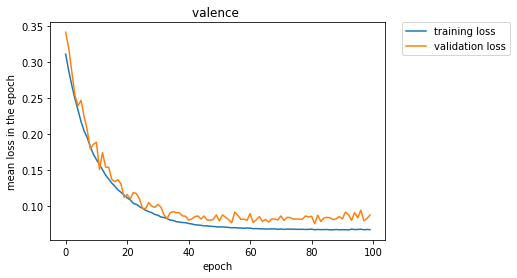

In [0]:
maxseqlen = train_LSTM(train_loader_multi, val_loader_multi, "cnn_multi0", input_size=128, dataset=multi_set, kind=0)

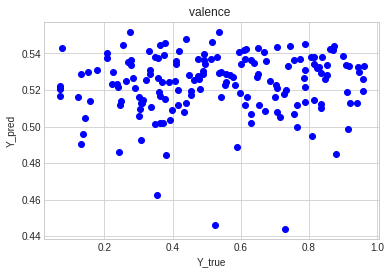

In [0]:
x=score_LSTM(test_loader_multi, "cnn_multi0", mels=128, maxseqlen=1293, kind=0)
scores.append(x)

#### Energy

1293
Epoch [1/100], Step [1/25], Loss: 0.4997
Epoch [1/100], Step [5/25], Loss: 0.5696
Epoch [1/100], Step [9/25], Loss: 0.4760
Epoch [1/100], Step [13/25], Loss: 0.4372
Epoch [1/100], Step [17/25], Loss: 0.4289
Epoch [1/100], Step [21/25], Loss: 0.3771
Epoch [1/100], Step [25/25], Loss: 0.5199
Epoch [2/100], Step [1/25], Loss: 0.4783
Epoch [2/100], Step [5/25], Loss: 0.3982
Epoch [2/100], Step [9/25], Loss: 0.3611
Epoch [2/100], Step [13/25], Loss: 0.4381
Epoch [2/100], Step [17/25], Loss: 0.4502
Epoch [2/100], Step [21/25], Loss: 0.4353
Epoch [2/100], Step [25/25], Loss: 0.4922
Epoch [3/100], Step [1/25], Loss: 0.4190
Epoch [3/100], Step [5/25], Loss: 0.4624
Epoch [3/100], Step [9/25], Loss: 0.4195
Epoch [3/100], Step [13/25], Loss: 0.3394
Epoch [3/100], Step [17/25], Loss: 0.3541
Epoch [3/100], Step [21/25], Loss: 0.3036
Epoch [3/100], Step [25/25], Loss: 0.3863
Epoch [4/100], Step [1/25], Loss: 0.3707
Epoch [4/100], Step [5/25], Loss: 0.3575
Epoch [4/100], Step [9/25], Loss: 0.3452

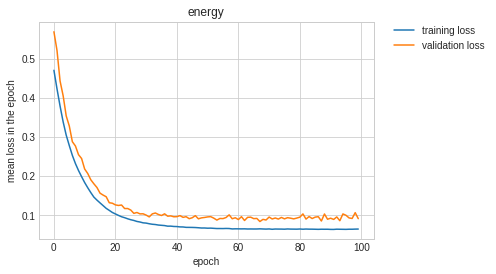

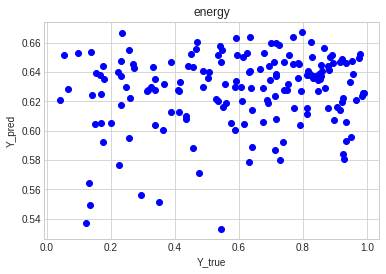

In [0]:
multi_set = SpectrogramDataset('../input/patreco3-multitask-affective-music/data/multitask_dataset/', train=True,
                                    class_mapping=None, max_length=-1,
                                    read_spec_fn=read_multi, kind=1)
# Train and Test loaders
train_loader_multi, val_loader_multi, test_loader_multi = torch_train_val_test_split(multi_set, batch_train=32, batch_eval=32, val_size=.15, test_size=.15)


maxseqlen = train_LSTM(train_loader_multi, val_loader_multi, "cnn_multi1", input_size=128, dataset=multi_set, kind=1)
x=score_LSTM(test_loader_multi, "cnn_multi1", mels=128, maxseqlen=maxseqlen, kind=1)
scores.append(x)

#### Danceability

1293
Epoch [1/100], Step [1/25], Loss: 0.3247
Epoch [1/100], Step [5/25], Loss: 0.3110
Epoch [1/100], Step [9/25], Loss: 0.2491
Epoch [1/100], Step [13/25], Loss: 0.3334
Epoch [1/100], Step [17/25], Loss: 0.3298
Epoch [1/100], Step [21/25], Loss: 0.3055
Epoch [1/100], Step [25/25], Loss: 0.3266
Epoch [2/100], Step [1/25], Loss: 0.2927
Epoch [2/100], Step [5/25], Loss: 0.2681
Epoch [2/100], Step [9/25], Loss: 0.2984
Epoch [2/100], Step [13/25], Loss: 0.2969
Epoch [2/100], Step [17/25], Loss: 0.2881
Epoch [2/100], Step [21/25], Loss: 0.2683
Epoch [2/100], Step [25/25], Loss: 0.2350
Epoch [3/100], Step [1/25], Loss: 0.2791
Epoch [3/100], Step [5/25], Loss: 0.2369
Epoch [3/100], Step [9/25], Loss: 0.2951
Epoch [3/100], Step [13/25], Loss: 0.2631
Epoch [3/100], Step [17/25], Loss: 0.2127
Epoch [3/100], Step [21/25], Loss: 0.2611
Epoch [3/100], Step [25/25], Loss: 0.2584
Epoch [4/100], Step [1/25], Loss: 0.2357
Epoch [4/100], Step [5/25], Loss: 0.2001
Epoch [4/100], Step [9/25], Loss: 0.2496

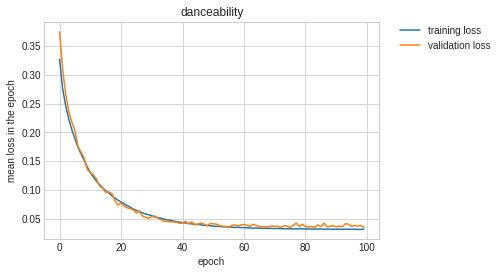

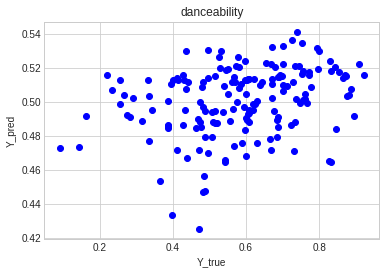

In [0]:
multi_set = SpectrogramDataset('../input/patreco3-multitask-affective-music/data/multitask_dataset/', train=True,
                                    class_mapping=None, max_length=-1,
                                    read_spec_fn=read_multi, kind=2)
# Train and Test loaders
train_loader_multi, val_loader_multi, test_loader_multi = torch_train_val_test_split(multi_set, batch_train=32, batch_eval=32, val_size=.15, test_size=.15)


maxseqlen = train_LSTM(train_loader_multi, val_loader_multi, "cnn_multi2", input_size=128, dataset=multi_set, kind=2)
x=score_LSTM(test_loader_multi, "cnn_multi2", mels=128, maxseqlen=maxseqlen, kind=2)
scores.append(x)

In [1]:
print(scores)
print(np.mean(scores))

[0.20420810998767436, 0.20989501870890484, 0.4344728728645557]
0.28285866718704494


Παρατηρούμε πως το LSTM δίνει το καλύτερο σκορ για το danceability, με τιμή 0.43, ενώ για τα άλλα δυο δεν αποδίδει το ίδιο καλά.

Τώρα, μένει να δούμε τι απόδοση θα δώσει το CNN για το regression των τριών χαρακτηριστικών.

### CNN

In [0]:
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
import re

def torch_train_val_test_split(dataset, batch_train, batch_eval,
                            val_size=.10, test_size=.10, shuffle=True, seed=32):
    # Uses seed and shuffling on dataset and produces a train loader, a validation loader and a test loader
    # with defining batch size
    
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    test_split = int(np.floor(test_size * dataset_size))
    
    if shuffle:
        np.random.seed(seed)  
        np.random.shuffle(indices)  # kanw shuffle exontas arxikopoisei to seed, settarismeno sto debug prokeimenou na exw idio apotelesma
        # indices px [1,4,0,2,5 ...]
    
    train_indices = indices[test_split+val_split:]
    val_indices = indices[:val_split]
    test_indices = indices[val_split:test_split+val_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset,
                              batch_size=batch_train,
                              sampler=train_sampler)
    val_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=val_sampler)
    test_loader = DataLoader(dataset,
                            batch_size=1,
                            sampler=test_sampler)
    
    return train_loader, val_loader, test_loader


def read_multi(spectrogram_file):
    '''
        spectrogram_file:  String, path file
    '''
    spectrogram = np.load(spectrogram_file)[0:128]
    return spectrogram.T


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])


# TODO: Comment on why padding is needed
class PaddingTransform(object):
    # Padding when needed
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        '''
            s: numpy array
        '''
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[:self.max_length] 

        if len(s) < self.max_length:
            # Padding in order to have same numpy shapes for all samples
            # since their timesteps dimension differs 
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1

        
class SpectrogramDataset(Dataset):
    
    def __init__(self, path, class_mapping=None, train=True, max_length=-1, read_spec_fn=read_multi, kind=-1):
        '''
            path:            String, the filepath of our data
            class_mapping:   Dict, the mapping of kinds of music
            train:           Boolean, (training or testing)
            max_length:      int
            read_spec_fn     function, the way that we would like to use the data
            kind:            int, 0: valence, 1: energy, 2: danceability
        '''
        
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_multi_labels(self.index, kind)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(labels).astype('float')

            
    def get_files_multi_labels(self, txt, kind):
        # Returns a list of file names and a list of their labels
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split(',') for l in fd.readlines()[1:]]
            
        files, labels = [], []
        for l in lines:
            label = l[kind+1]
            labels.append(label)
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            _id = int(l[0])
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            
        return files, labels

    
    def __getitem__(self, item):
        # Returns padded item, item label, l
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item]

    
    def __len__(self):
        # Returns the number of dataset samples
        return len(self.labels)

    


Παρακάτω, παρουσιάζουμε το CNN Model που χρησιμοποιούμε για το regression.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class CNN(nn.Module):

    def __init__(self):
    
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            
        )    
        self.layer2 = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=5),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) 
            
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            
        )
        self.fc1 = nn.Linear(9856, 1)
        
        
    def forward(self, x):
        # Forward function of CNN
        
        out = self.layer1(x)     # conv1
        out = self.layer2(out)   # conv2
        out = self.layer3(out)   # conv3
        out = self.layer4(out)   # conv4
        out = out.view(out.size(0), -1)
        out = nn.Dropout2d(p=0.1)(out)
        out = self.fc1(out)      # fully-connected1
        return out



from torch.optim import lr_scheduler
def train_CNN(train_loader, val_loader, val_name, mels, dataset, kind):
    '''
        train_loader:  Dataloader
        val_loader:    Dataloader
        val_name:      String
        mels:          int, input size
        dataset:       SpectrumDataset
    '''
    
    val_name += ".pkl"
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Hyper-parameters
    num_epochs = 250
    learning_rate = 0.0001
    lambda1 = 0.00002
    
    maxseqlen = dataset.max_length

    model = CNN().to(device)
    model = model.double()

    # Loss and optimizer
    criterion = nn.MSELoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train the model
    train_loss = []
    vl = []
    tl = []
    best_val_loss = np.Inf
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        train_loss.append([])
        val_loss = 0

        count = 0
        model.eval()
        with torch.no_grad():
            for i, (feats, labels) in enumerate(val_loader):
                # Validation set
                feats = feats.view(-1, 1, maxseqlen, mels).to(device)
                labels = labels.to(device).double()

                # Forward pass
                outputs = model.forward(feats)
                MSE_loss = criterion(outputs, labels)
                fc1_params = torch.cat([x.view(-1) for x in model.fc1.parameters()])
                l1_regularization = lambda1 * torch.norm(fc1_params, 1)
                loss = MSE_loss + l1_regularization
                val_loss += loss.item()
                count += 1

            vl.append(val_loss / count)

            if val_loss <= best_val_loss and epoch > 3:
                print("changed val")
                # Keep the model with minimum validation loss
                best_val_loss = val_loss
                joblib_file = val_name  
                torch.save(model, joblib_file)

        model.train()
        for i, (feats, labels) in enumerate(train_loader):
            
            # Training set
            feats_reshape = feats.view(-1, 1, maxseqlen, mels).to(device)
            labels = labels.to(device).double()

            # Forward pass
            outputs = model.forward(feats_reshape)
            MSE_loss = criterion(outputs, labels)
            fc1_params = torch.cat([x.view(-1) for x in model.fc1.parameters()])
            l1_regularization = lambda1 * torch.norm(fc1_params, 1)
            loss = MSE_loss + l1_regularization
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss[epoch].append(loss.item())
            
        print("epoch: " + str(epoch+1), "\nTrain loss:\t\t", np.mean(train_loss[epoch]))
        for param_group in optimizer.param_groups:
            print("LR", param_group['lr'])
        print("Validation loss:\t", val_loss / count)
        print()
        
        tl.append(np.mean(train_loss[epoch]))

    tl=np.array(tl)
    vl=np.array(vl)
    names=['valence ', 'energy', 'danceability']
    # Plotting learning curve
    plt.figure()
    plt.plot(tl[2:], label="training loss")
    plt.plot(vl[2:], label="validation loss")
    plt.xlabel('epoch')
    plt.ylabel('mean loss in the epoch')
    plt.title(names[kind])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()
    return maxseqlen
    
            
import warnings
warnings.simplefilter("ignore", UserWarning)

from scipy import stats
def score_CNN(test_loader, file_model, mels, maxseqlen, kind):
    # Estimating the model with classification report
    '''
        test_loader:   Dataloader
        file_model:    String, filepath of best model
        mels:          int, input size
        maxseqlen:     int
    '''
        
    file_model += ".pkl"
    model = torch.load(file_model)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # For batch normalization and dropout in testing
    model.eval()
    
    with torch.no_grad():
        y_pred = []
        y_true = []
        for i, (feats, labels) in enumerate(test_loader):
            feats = feats.view(-1, 1, maxseqlen, mels).to(device)
            labels = labels.to(device).double()
            predicted = model.forward(feats)
            for j in range(len(predicted)):
                y_pred.append(predicted[j].item())
                y_true.append(labels[j].item())
                
        names=['valence ', 'energy', 'danceability']
        %matplotlib inline
        import matplotlib.pyplot as plt

        x=np.array(y_true)
        y=np.array(y_pred)
        
        plt.style.use('seaborn-whitegrid')
        plt.plot(x , y, 'o', color='blue'); 
        plt.title(names[kind])
        plt.xlabel("Y_true")
        plt.ylabel("Y_pred")

        return stats.spearmanr(y_pred, y_true)[0]


#### Valence

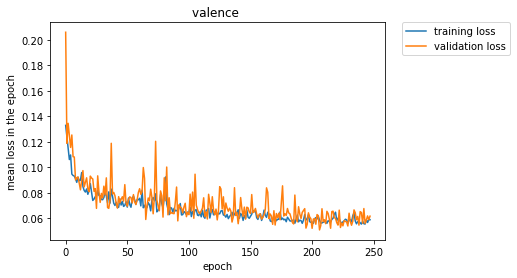

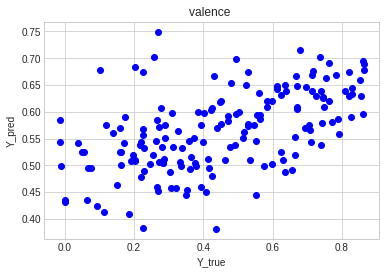

In [0]:
multi_set = SpectrogramDataset('../input/patreco3-multitask-affective-music/data/multitask_dataset/', train=True,
                                    class_mapping=None, max_length=-1,
                                    read_spec_fn=read_multi, kind=0)
# Train and Test loaders
train_loader_multi, val_loader_multi, test_loader_multi = torch_train_val_test_split(multi_set, batch_train=32, batch_eval=32, val_size=.15, test_size=.15)


maxseqlen = train_CNN(train_loader_multi, val_loader_multi, "cnn_multi0", mels=128, dataset=multi_set, kind=0)
x=score_CNN(test_loader_multi, "cnn_multi0", mels=128, maxseqlen=maxseqlen, kind=0)
scores.append(x)

#### Energy

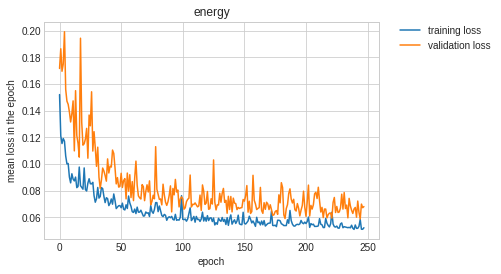

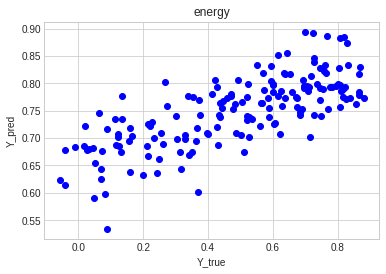

In [0]:
multi_set = SpectrogramDataset('../input/patreco3-multitask-affective-music/data/multitask_dataset/', train=True,
                                    class_mapping=None, max_length=-1,
                                    read_spec_fn=read_multi, kind=1)
# Train and Test loaders
train_loader_multi, val_loader_multi, test_loader_multi = torch_train_val_test_split(multi_set, batch_train=32, batch_eval=32, val_size=.15, test_size=.15)


maxseqlen = train_CNN(train_loader_multi, val_loader_multi, "cnn_multi1", mels=128, dataset=multi_set, kind=1)
x=score_CNN(test_loader_multi, "cnn_multi1", mels=128, maxseqlen=maxseqlen, kind=1)
scores.append(x)

#### Danceability

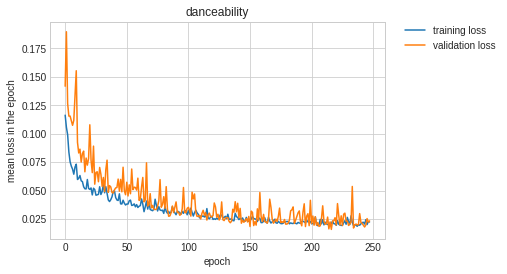

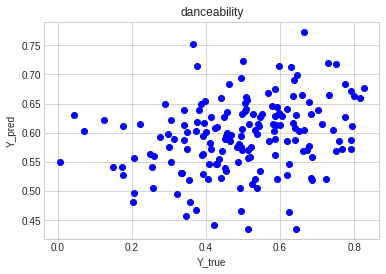

In [0]:
multi_set = SpectrogramDataset('../input/patreco3-multitask-affective-music/data/multitask_dataset/', train=True,
                                    class_mapping=None, max_length=-1,
                                    read_spec_fn=read_multi, kind=2)
# Train and Test loaders
train_loader_multi, val_loader_multi, test_loader_multi = torch_train_val_test_split(multi_set, batch_train=32, batch_eval=32, val_size=.15, test_size=.15)


maxseqlen = train_CNN(train_loader_multi, val_loader_multi, "cnn_multi2", mels=128, dataset=multi_set, kind=2)
x=score_CNN(test_loader_multi, "cnn_multi2", mels=128, maxseqlen=maxseqlen, kind=2)
scores.append(x)

In [0]:
print(scores)
print(np.mean(scores))

[0.2090602301719673, 0.283947833368725, 0.40945899398828773]
 0.3008223525


Βλέπουμε πως το CNN παρουσιάζει μεγαλύτερη μέση τιμή του σκορ από ότι το LSTM, παρόλα αυτά το τελευταίο εμφανίζει το μεγαλύτερο σκορ από τα δύο στο regression.

## Βήμα 9(α). Transfer Learning

**Paper**  

Πληροφορούμαστε πως η μεταφορά γνώσης από παραπλήσιο task, μαζί με κατάλληλο fine-tuning, δίνει καλύτερα αποτελέσματα από την εκπαίδευση αποκλειστικά στο συγκεκριμένο για το task dataset. Ακόμα, τονίζεται πως όσο περισσότερα επίπεδα χρησιμοποιούνται στο transfer, τόσο καλύτερη απόδοση έχουμε.

Στο transfer learning, θα εκπαιδεύσουμε το CNN του βήματος 7 (μεγαλύτερου dataset) και θα μεταφέρουμε την εκπαίδευσή του σε ένα CNN δίκτυο του βήματος 8, δεδομένου πως στα συνελικτικά δίκτυα τα πρώτα επίπεδα τείνουν να μαθαίνουν τα ίδια χαρακτηριστικά. Αυτό το βήμα απαίτει μεγάλη κατανάλωση της RAM, αλλά και αρκετό χρόνο, προκειμένου να ολοκληρωθούν και οι δύο εκπαιδεύσεις. Αξίζει να σημειωθεί ότι το transfer learning επιτυγχάνεται με τη χρήση της παραμέτρου strict της load_dict_state που την καθιστούμε ίση με False.

In [0]:
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
import re

# Combine similar classes and remove underrepresented classes
class_mapping = {
    'Rock': 'Rock',
    'Psych-Rock': 'Rock',
    'Indie-Rock': None,
    'Post-Rock': 'Rock',
    'Psych-Folk': 'Folk',
    'Folk': 'Folk',
    'Metal': 'Metal',
    'Punk': 'Metal',
    'Post-Punk': None,
    'Trip-Hop': 'Trip-Hop',
    'Pop': 'Pop',
    'Electronic': 'Electronic',
    'Hip-Hop': 'Hip-Hop',
    'Classical': 'Classical',
    'Blues': 'Blues',
    'Chiptune': 'Electronic',
    'Jazz': 'Jazz',
    'Soundtrack': None,
    'International': None,
    'Old-Time': None
}

def torch_train_val_split(dataset, batch_train, batch_eval,
                            val_size=.2, shuffle=True, seed=None):
    # Uses seed and shuffling on dataset and produces a train loader and a validation loader 
    # with defining batch size
    
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    if shuffle:
        np.random.seed(seed)  
        np.random.shuffle(indices)  # kanw shuffle exontas arxikopoisei to seed, settarismeno sto debug prokeimenou na exw idio apotelesma
        # indices px [1,4,0,2,5 ...]
    
    train_indices = indices[val_split:]
    val_indices = indices[:val_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset,
                              batch_size=batch_train,
                              sampler=train_sampler)
    val_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=val_sampler)
    return train_loader, val_loader


def read_mel_spectrogram(spectrogram_file):
    '''
        spectrogram_file:  String, path file
    '''
    spectrogram = np.load(spectrogram_file)[:128]
    return spectrogram.T


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])


class PaddingTransform(object):
    # Padding when needed
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        '''
            s: numpy array
        '''
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[:self.max_length] 

        if len(s) < self.max_length:
            # Padding in order to have same numpy shapes for all samples
            # since their timesteps dimension differs 
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1

        
class SpectrogramDataset(Dataset):
    
    def __init__(self, path, class_mapping=None, train=True, max_length=-1, read_spec_fn=read_mel_spectrogram):
        '''
            path:            String, the filepath of our data
            class_mapping:   Dict, the mapping of kinds of music
            train:           Boolean, (training or testing)
            max_length:      int
            read_spec_fn     function, the way that we would like to use the data
        '''
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_labels(self.index, class_mapping)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(self.label_transformer.fit_transform(labels)).astype('int64')

            
    def get_files_labels(self, txt, class_mapping):
        # Returns a list of file names and a list of their labels
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            label = l[1]
            if class_mapping:
                label = class_mapping[l[1]]
            if label is None:
                continue
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            _id = l[0].split('.')[0]
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            labels.append(label)
            
        return files, labels

    
    def __getitem__(self, item):
        # Returns padded item, item label, l
        l = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], l

    
    def __len__(self):
        # Returns the number of dataset samples
        return len(self.labels)


if __name__ == "__main__":
    
    ##################################################################################
    # load single synced mel spectrograms
    ##################################################################################
    # Dataset
    mel_specs = SpectrogramDataset('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', train=True,
                                        class_mapping=class_mapping, max_length=-1,
                                        read_spec_fn=read_mel_spectrogram)
    # Train and Test loaders
    train_loader_mel, val_loader_mel = torch_train_val_split(mel_specs, 32, 32, val_size=.33)
    test_dataset_mel = SpectrogramDataset('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/', train=False,
                                            class_mapping=class_mapping, max_length=-1,
                                            read_spec_fn=read_mel_spectrogram)
    
    test_loader_mel = DataLoader(test_dataset_mel, batch_size=1)

Το παρακάτω είναι το αρχικό CNN που κάνει train στο fma_genre_spectrograms, όπως στο βήμα 7.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class CNN(nn.Module):

    def __init__(self):
    
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        )    
        self.layer2 = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),    
            
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=5),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        )
        self.layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        )
        self.fc1 = nn.Linear(19712*4, 10)
        
        
    def forward(self, x):
        # Forward function of CNN
        
        out = self.layer1(x)     # conv1
        out = self.layer2(out)   # conv2
        out = self.layer3(out)   # conv3
        out = self.layer4(out)   # conv4
        out = out.view(out.size(0), -1)
        out = nn.Dropout2d(p=0.28)(out) # dropout
        out = self.fc1(out)      # fully-connected1
        return out


def train_CNN(train_loader, val_loader, val_name, mels, dataset):
    '''
        train_loader:  Dataloader
        val_loader:    Dataloader
        val_name:      String
        mels:          int, input size
        dataset:       SpectrumDataset
    '''
    
    path = val_name + ".pt" 
    val_name += ".pkl"
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Hyper-parameters
    num_classes = 10
    num_epochs = 50
    learning_rate = 0.0001
    momentum = 0
    
    maxseqlen = dataset.max_length

    model = CNN().to(device)
    model = model.double()

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    # Train the model
    train_loss = []
    vl = []
    tl = []
    min_val_loss = np.Inf
    n_epochs_stop = 10000000
    epochs_no_improve = 0
    best_val_loss = np.Inf
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        train_loss.append([])
        val_loss = 0
        early_stop = False


        for i, (feats, labels, lengths) in enumerate(val_loader):
            # Validation set
            feats_reshape = feats.reshape(-1, 1, maxseqlen, mels).to(device)
            labels = labels.to(device) 
            labels = torch.tensor(labels, dtype=torch.long, device=device)
            lengths = lengths.to(device)

            # Forward pass
            outputs = model.forward(feats_reshape)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

        vl.append(val_loss / i)
        
        if val_loss <= best_val_loss:
            # Keep the model with minimum validation loss
            best_val_loss = val_loss
            joblib_file = val_name  
            joblib.dump(model, joblib_file)
            torch.save(model.state_dict(), path)

        v_loss = 0
        for i, (feats, labels, lengths) in enumerate(train_loader):
            # Training set
            feats_reshape = feats.reshape(-1, 1, maxseqlen, mels).to(device)
            labels = labels.to(device) 
            labels = torch.tensor(labels, dtype=torch.long, device=device)
            lengths = lengths.to(device)

            # Forward pass
            outputs = model.forward(feats_reshape)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss[epoch].append(loss.item())

            # epoch loss
            v_loss += loss
            v_loss = v_loss / len(train_loader)

            # If the validation loss is at a minimum
            if v_loss < min_val_loss:

                #torch.save(model)
                epochs_no_improve = 0
                min_val_loss = v_loss

            else:
                epochs_no_improve += 1
            # Check early stopping condition           
            if epochs_no_improve == n_epochs_stop:
                print('Early stopping!' )
                early_stop = True
                break
            else:
                continue
            break
        if early_stop:
            print("Stopped")
            break
            
        tl.append(np.mean(train_loss[epoch]))

    # Tranform losses to numpy arrays
    tl=np.array(tl)
    vl=np.array(vl)
        
    # Plotting learning curve
    plt.figure()
    plt.plot(tl, label="training loss")
    plt.plot(vl, label="validation loss")
    plt.xlabel('epoch')
    plt.ylabel('mean loss in the epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()
    
    return maxseqlen
    
            
import warnings
warnings.simplefilter("ignore", UserWarning)

from sklearn.metrics import classification_report
def score_CNN(test_loader, file_model, mels, maxseqlen):
    # Estimating the model with classification report
    '''
        test_loader:   Dataloader
        file_model:    String, filepath of best model
        mels:          int, input size
        maxseqlen:     int
    '''
        
    file_model += ".pkl"
    model = joblib.load(file_model)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Disable batch normalization and dropout in testing
    model.eval()
    
    with torch.no_grad():
        correct = 0
        total = 0
        y_pred = []
        y_true = []
        for feats, labels, lengths in test_loader:
            feats = feats.reshape(-1, 1, maxseqlen, mels).to(device)
            labels = labels.to(device)
            labels = torch.tensor(labels, dtype=torch.long, device=device)
            outputs = model.forward(feats).double()
            _, predicted = torch.max(outputs.data, -1)
            y_pred.append(predicted.item())
            y_true.append(labels.item())

        print(classification_report(y_true, y_pred))

In [0]:
maxseqlen = train_CNN(train_loader_mel, val_loader_mel, "cnn_single_mel", mels=128, dataset=mel_specs)

Αφού τελειώσαμε με την εκπαίδευση του πρώτου CNN, το οποίο είχε 10 εξόδους (classification), τώρα θα κάνουμε το transfer learning στο νέο CNN που έχει μία έξοδο (regression). Το τελευταίο θα έχει αρχικοποιημένα τα βάρη του CNN από την εκπαιδεύση του πρώτου, με στόχο μια καλύτερη επίδοση στο regression. 

In [0]:
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
import re

def torch_train_val_test_split(dataset, batch_train, batch_eval,
                            val_size=.10, test_size=.10, shuffle=True, seed=32):
    # Uses seed and shuffling on dataset and produces a train loader, a validation loader and a test loader
    # with defining batch size
    
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    test_split = int(np.floor(test_size * dataset_size))
    
    if shuffle:
        np.random.seed(seed)  
        np.random.shuffle(indices)  # kanw shuffle exontas arxikopoisei to seed, settarismeno sto debug prokeimenou na exw idio apotelesma
        # indices px [1,4,0,2,5 ...]
    
    train_indices = indices[test_split+val_split:]
    val_indices = indices[:val_split]
    test_indices = indices[val_split:test_split+val_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset,
                              batch_size=batch_train,
                              sampler=train_sampler)
    val_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=val_sampler)
    test_loader = DataLoader(dataset,
                            batch_size=1,
                            sampler=test_sampler)
    
    return train_loader, val_loader, test_loader


def read_multi(spectrogram_file):
    '''
        spectrogram_file:  String, path file
    '''
    spectrogram = np.load(spectrogram_file)[0:128]
    return spectrogram.T


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])


# TODO: Comment on why padding is needed
class PaddingTransform(object):
    # Padding when needed
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        '''
            s: numpy array
        '''
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[:self.max_length] 

        if len(s) < self.max_length:
            # Padding in order to have same numpy shapes for all samples
            # since their timesteps dimension differs 
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1

        
class SpectrogramDataset(Dataset):
    
    def __init__(self, path, class_mapping=None, train=True, max_length=-1, read_spec_fn=read_multi, kind=-1):
        '''
            path:            String, the filepath of our data
            class_mapping:   Dict, the mapping of kinds of music
            train:           Boolean, (training or testing)
            max_length:      int
            read_spec_fn     function, the way that we would like to use the data
            kind:            int, 0: valence, 1: energy, 2: danceability
        '''
        
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_multi_labels(self.index, kind)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(labels).astype('float')

            
    def get_files_multi_labels(self, txt, kind):
        # Returns a list of file names and a list of their labels
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split(',') for l in fd.readlines()[1:]]
            
        files, labels = [], []
        for l in lines:
            label = l[kind+1]
            labels.append(label)
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            _id = int(l[0])
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            
        return files, labels

    
    def __getitem__(self, item):
        # Returns padded item, item label, l
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item]

    
    def __len__(self):
        # Returns the number of dataset samples
        return len(self.labels)

    
if __name__ == "__main__":
    
    ##################################################################################
    # load multitask_dataset
    ##################################################################################
    # Dataset
    multi_set = SpectrogramDataset('../input/patreco3-multitask-affective-music/data/multitask_dataset/', train=True,
                                        class_mapping=None, max_length=-1,
                                        read_spec_fn=read_multi, kind=2)
    # Train and Test loaders
    train_loader_multi, val_loader_multi, test_loader_multi = torch_train_val_test_split(multi_set, batch_train=32, batch_eval=32, val_size=.15, test_size=.15)

Παρακάτω, δείχνουμε την βασική συνάρτηση του transfer learning που μεταφέρει την εκπαίδευση από το ένα δίκτυο στο άλλο.

In [0]:
def transfer(vanilla, path='../input/cnn-single-met/cnn_single_mel.pt'):
    # Transfer Learning
    '''
        vanilla:  nn.Module
    '''
    vanilla.load_state_dict(torch.load(path), strict=False)
    return vanilla

Στο μοντέλο αυτό, χρησιμοποιούμε πέρα από τo αρχικοποιημένο 4-layer CNN, ένα fully-connected που τελικά το περνάμε από μία relu για να κόβει τις αρνητικές τιμές εξόδου.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class CNN_4layer(nn.Module):

    def __init__(self):
    
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        )    
        self.layer2 = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),    
            
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=5),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        )
        self.layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        )
        self.fc = nn.Linear(19712*4, 1)
        self.relu = nn.ReLU()
        
        
    def forward(self, x):
        # Forward function of CNN
        
        out = self.layer1(x)     # conv1
        out = self.layer2(out)   # conv2
        out = self.layer3(out)   # conv3
        out = self.layer4(out)   # conv4
        out = out.view(out.size(0), -1)
        out = nn.Dropout2d(p=0.1)(out)
        out = self.fc(out)      # fully-connected1
        out = self.relu(out)
        return out

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

def train_CNN(train_loader, val_loader, val_name, mels, dataset):
    '''
        train_loader:  Dataloader
        val_loader:    Dataloader
        val_name:      String
        mels:          int, input size
        dataset:       SpectrumDataset
    '''
    
    val_name += ".pkl"
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Hyper-parameters
    num_epochs = 150
    learning_rate = 0.00001
    lambda1 = 0.00000002
    
    maxseqlen = dataset.max_length
    
    # Transfer Learning classifier
    model = CNN_4layer()
    model = transfer(model)
    
    model = model.to(device)
    model = model.double()
    
    # Loss and optimizer
    criterion = nn.MSELoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # Train the model
    train_loss = []
    vl = []
    tl = []
    best_val_loss = np.Inf
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        train_loss.append([])
        val_loss = 0

        count = 0
        model.eval()
        with torch.no_grad():
            for i, (feats, labels) in enumerate(val_loader):
                # Validation set
                feats = feats.view(-1, 1, maxseqlen, mels).to(device)
                labels = labels.to(device).double()

                # Forward pass
                outputs = model.forward(feats)
                MSE_loss = criterion(outputs, labels)
                fc1_params = torch.cat([x.view(-1) for x in model.fc.parameters()])
                l1_regularization = lambda1 * torch.norm(fc1_params, 1)
                loss = MSE_loss + l1_regularization
                val_loss += loss.item()
                count += 1

            vl.append(val_loss / count)

            if val_loss <= best_val_loss and epoch > 3:
                print("changed val")
                # Keep the model with minimum validation loss
                best_val_loss = val_loss
                joblib_file = val_name  
                torch.save(model, joblib_file)

        model.train()
        for i, (feats, labels) in enumerate(train_loader):
            
            # Training set
            feats_reshape = feats.view(-1, 1, maxseqlen, mels).to(device)
            labels = labels.to(device).double()

            # Forward pass
            outputs = model.forward(feats_reshape)
            MSE_loss = criterion(outputs, labels)
            fc1_params = torch.cat([x.view(-1) for x in model.fc.parameters()])
            l1_regularization = lambda1 * torch.norm(fc1_params, 1)
            loss = MSE_loss + l1_regularization
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss[epoch].append(loss.item())
            
        print("epoch: " + str(epoch+1), "\nTrain loss:\t\t", np.mean(train_loss[epoch]))
        for param_group in optimizer.param_groups:
            print("LR", param_group['lr'])
        print("Validation loss:\t", val_loss / count)
        print()
        
        tl.append(np.mean(train_loss[epoch]))

    # Tranform losses to numpy arrays
    tl = np.array(tl)
    vl = np.array(vl)
        
    # Plotting learning curve
    plt.figure()
    plt.plot(tl[2:], label="training loss")
    plt.plot(vl[2:], label="validation loss")
    plt.xlabel('epoch')
    plt.ylabel('mean loss in the epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()
    
    
    return maxseqlen, tl, vl
    
            
import warnings
warnings.simplefilter("ignore", UserWarning)

from scipy import stats
def score_CNN(test_loader, file_model, mels, maxseqlen):
    # Estimating the model with classification report
    '''
        test_loader:   Dataloader
        file_model:    String, filepath of best model
        mels:          int, input size
        maxseqlen:     int
    '''
        
    file_model += ".pkl"
    model = torch.load(file_model)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # For batch normalization and dropout in testing
    model.eval()
    
    with torch.no_grad():
        y_pred = []
        y_true = []
        for i, (feats, labels) in enumerate(test_loader):
            feats = feats.view(-1, 1, maxseqlen, mels).to(device)
            labels = labels.to(device).double()
            predicted = model.forward(feats)
            for j in range(len(predicted)):
                y_pred.append(predicted[j].item())
                y_true.append(labels[j].item())
                              
        plt.scatter(y_true, y_pred)
        print(stats.spearmanr(y_true, y_pred))

epoch: 1 
Train loss:		 0.1985598192557827
LR 1e-05
Validation loss:	 0.2026093526022172

epoch: 2 
Train loss:		 0.18297159036345076
LR 1e-05
Validation loss:	 0.20800406522200163

epoch: 3 
Train loss:		 0.1728870627933933
LR 1e-05
Validation loss:	 0.17310687441352957

epoch: 4 
Train loss:		 0.17095724774528873
LR 1e-05
Validation loss:	 0.16107120669015662

changed val
epoch: 5 
Train loss:		 0.16910012611841374
LR 1e-05
Validation loss:	 0.19853938342511876

changed val
epoch: 6 
Train loss:		 0.1629739664677898
LR 1e-05
Validation loss:	 0.1700134965237894

changed val
epoch: 7 
Train loss:		 0.16796095325968893
LR 1e-05
Validation loss:	 0.15335868795643257

changed val
epoch: 8 
Train loss:		 0.1632860345870206
LR 1e-05
Validation loss:	 0.13310301145472148

epoch: 9 
Train loss:		 0.16455877078300457
LR 1e-05
Validation loss:	 0.17257199131885914

epoch: 10 
Train loss:		 0.15473751479213826
LR 1e-05
Validation loss:	 0.150431193461341

epoch: 11 
Train loss:		 0.158926953517

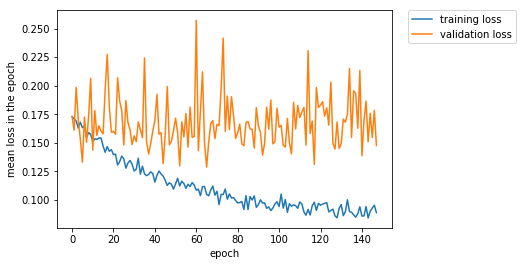

In [0]:
maxseqlen, t, v = train_CNN(train_loader_multi, val_loader_multi, "cnn_multi", mels=128, dataset=multi_set) 

SpearmanrResult(correlation=0.04449061387529283, pvalue=0.5668867691714627)


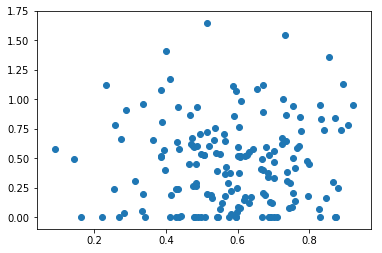

In [0]:
score_CNN(test_loader_multi, "cnn_multi", mels=128, maxseqlen=1293)

Παρατηρούμε ότι το transfer learning δεν απέδωσε όπως ίσως περιμέναμε. Αξίζει να σημειωθεί πως οι αποκλίσεις είναι αρκετά μεγάλες, κάτι που, ωστόσο, οφείλεται στο γεγονός ότι η μετρική αυτή εύκολα αυξομειώνεται, αφού δεν έχουμε κάνει βελτιστοποιήση πάνω σε αυτή ή δεν έχει γίνει καλό fine tuning.

Μια καλύτερη ίδεα που δεν υλοποιήσαμε ήταν να παωναμε το CNN (κωδικοποιητής) στις τιμές που πήραμε από το αρχικό και να εκπαιδεύαμε μόνο τον αποκωδικοποιητή (fully-connected) και σε επόμενη φάση να τα εκπαιδεύαμε συνδυαστικά.

## Βήμα 9(β). Multitasking

**Paper**   
Στο paper τονίζεται πως ένα και μόνο πολυδίκτυο χρησιμοποιήθηκε για να μάθει πολλά ετερόκλητα tasks. Η απόδοση του δικτύου αν και ήταν χειρότερη των βέλτιστων για κάθε task χωριστά, παρείχε αρκετά καλή επίδοση σε όλα, ειδικά συγκρινόμενο με άλλα σύγχρονα συστήματα. Υπογραμμίζεται επίσης ότι ακόμα και μέρη του υποδικτύου που χρησίμευαν αμελητέα σε κάποια task, όταν επαναπροστίθενταν, παρείχαν όχι χειρότερη απόδοση σε αυτά.

#### Convolutional

In [0]:
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
import re

def torch_train_val_test_split(dataset, batch_train, batch_eval,
                            val_size=.10, test_size=.10, shuffle=True, seed=32):
    # Uses seed and shuffling on dataset and produces a train loader, a validation loader and a test loader
    # with defining batch size
    
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    test_split = int(np.floor(test_size * dataset_size))
    
    if shuffle:
        np.random.seed(seed)  
        np.random.shuffle(indices)  # kanw shuffle exontas arxikopoisei to seed, settarismeno sto debug prokeimenou na exw idio apotelesma
        # indices px [1,4,0,2,5 ...]
    
    train_indices = indices[test_split+val_split:]
    val_indices = indices[:val_split]
    test_indices = indices[val_split:test_split+val_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset,
                              batch_size=batch_train,
                              sampler=train_sampler)
    val_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=val_sampler)
    test_loader = DataLoader(dataset,
                            batch_size=1,
                            sampler=test_sampler)
    
    return train_loader, val_loader, test_loader


def read_multi(spectrogram_file):
    '''
        spectrogram_file:  String, path file
    '''
    spectrogram = np.load(spectrogram_file)[0:128]
    return spectrogram.T


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])


# TODO: Comment on why padding is needed
class PaddingTransform(object):
    # Padding when needed
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        '''
            s: numpy array
        '''
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[:self.max_length] 

        if len(s) < self.max_length:
            # Padding in order to have same numpy shapes for all samples
            # since their timesteps dimension differs 
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1

        
class SpectrogramDataset(Dataset):
    
    def __init__(self, path, class_mapping=None, train=True, max_length=-1, read_spec_fn=read_multi, kind=-1):
        '''
            path:            String, the filepath of our data
            class_mapping:   Dict, the mapping of kinds of music
            train:           Boolean, (training or testing)
            max_length:      int
            read_spec_fn     function, the way that we would like to use the data
            kind:            int, 0: valence, 1: energy, 2: danceability
        '''
        
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_multi_labels(self.index)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(labels)

            
    def get_files_multi_labels(self, txt):
        # Returns a list of file names and a list of their labels
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split(',') for l in fd.readlines()[1:]]
            
        files, labels = [], []
        for l in lines:
            label = (float(l[1]),float(l[2]),float(l[3]))
            labels.append(label)
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            _id = int(l[0])
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            
        return files, labels

    
    def __getitem__(self, item):
        # Returns padded item, item label, l
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item]

    
    def __len__(self):
        # Returns the number of dataset samples
        return len(self.labels)

    


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class CNN(nn.Module):

    def __init__(self):
    
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            
        )    
        self.layer2 = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=5),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) 
            
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            
        )
        self.fc1 = nn.Linear(9856, 3)
        
        
    def forward(self, x):
        # Forward function of CNN
        
        out = self.layer1(x)     # conv1
        out = self.layer2(out)   # conv2
        out = self.layer3(out)   # conv3
        out = self.layer4(out)   # conv4
        out = out.view(out.size(0), -1)
        out = nn.Dropout2d(p=0.1)(out)
        out = self.fc1(out)      # fully-connected1
        return out



from torch.optim import lr_scheduler
def train_CNN(train_loader, val_loader, val_name, mels, dataset):
    '''
        train_loader:  Dataloader
        val_loader:    Dataloader
        val_name:      String
        mels:          int, input size
        dataset:       SpectrumDataset
    '''
    
    val_name += ".pkl"
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Hyper-parameters
    num_epochs = 350
    learning_rate = 0.0001
    lambda1 = 0.00002
    
    maxseqlen = dataset.max_length

    model = CNN().to(device)
    model = model.double()

    # Loss and optimizer
    criterion = nn.MSELoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train the model
    train_loss = []
    vl = []
    tl = []
    best_val_loss = np.Inf
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        train_loss.append([])
        val_loss = 0

        count = 0
        model.eval()
        with torch.no_grad():
            for i, (feats, labels) in enumerate(val_loader):
                # Validation set
                feats = feats.view(-1, 1, maxseqlen, mels).to(device)
                labels = labels.to(device).double()
#                 print(labels)
                # Forward pass
                outputs = model.forward(feats)
                MSE_loss = criterion(outputs, labels)
                fc1_params = torch.cat([x.view(-1) for x in model.fc1.parameters()])
                l1_regularization = lambda1 * torch.norm(fc1_params, 1)
                loss = MSE_loss + l1_regularization
                val_loss += loss.item()
                count += 1

            vl.append(val_loss / count)

            if val_loss <= best_val_loss and epoch > 3:
                print("changed val")
                # Keep the model with minimum validation loss
                best_val_loss = val_loss
                joblib_file = val_name  
                torch.save(model, joblib_file)

        model.train()
        for i, (feats, labels) in enumerate(train_loader):
            
            # Training set
            feats_reshape = feats.view(-1, 1, maxseqlen, mels).to(device)
            labels = labels.to(device).double()

            # Forward pass
            outputs = model.forward(feats_reshape)
            MSE_loss = criterion(outputs, labels)
            fc1_params = torch.cat([x.view(-1) for x in model.fc1.parameters()])
            l1_regularization = lambda1 * torch.norm(fc1_params, 1)
            loss = MSE_loss + l1_regularization
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss[epoch].append(loss.item())
            
        print("epoch: " + str(epoch+1), "\nTrain loss:\t\t", np.mean(train_loss[epoch]))
        for param_group in optimizer.param_groups:
            print("LR", param_group['lr'])
        print("Validation loss:\t", val_loss / count)
        print()
        
        tl.append(np.mean(train_loss[epoch]))

    tl=np.array(tl)
    vl=np.array(vl)

    
    # Plotting learning curve
    plt.figure()
    plt.plot(tl[2:], label="training loss")
    plt.plot(vl[2:], label="validation loss")
    plt.xlabel('epoch')
    plt.ylabel('mean loss in the epoch')
    plt.title('multitask learning curve')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()
    return maxseqlen
    
            
import warnings
warnings.simplefilter("ignore", UserWarning)

from scipy import stats
def score_CNN(test_loader, file_model, mels, maxseqlen):
    # Estimating the model with classification report
    '''
        test_loader:   Dataloader
        file_model:    String, filepath of best model
        mels:          int, input size
        maxseqlen:     int
    '''
        
    file_model += ".pkl"
    model = torch.load(file_model)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # For batch normalization and dropout in testing
    model.eval()
    
    with torch.no_grad():
        y_pred1 = []
        y_true1 = []
        
        y_pred2 = []
        y_true2 = []
        
        y_pred3 = []
        y_true3 = []
        
        for i, (feats, labels) in enumerate(test_loader):
            feats = feats.view(-1, 1, maxseqlen, mels).to(device)
            labels = labels.to(device).double()
            predicted = model.forward(feats)
            for j in range(len(predicted)):
                y_pred1.append(predicted[j][0].item())
                y_true1.append(labels[j][0].item())
                
                y_pred2.append(predicted[j][1].item())
                y_true2.append(labels[j][1].item())
                
                y_pred3.append(predicted[j][2].item())
                y_true3.append(labels[j][2].item())
                
        names=['valence ', 'energy', 'danceability']
        %matplotlib inline
        import matplotlib.pyplot as plt
        
        x=np.array(y_true1)
        y=np.array(y_pred1)  
        plt.figure()
        plt.style.use('seaborn-whitegrid')
        plt.plot(x, y, 'o', color='blue')
        plt.title(names[0])
        plt.xlabel("Y_true")
        plt.ylabel("Y_pred")
        
        
        x=np.array(y_true2)
        y=np.array(y_pred2)      
        plt.figure()
        plt.style.use('seaborn-whitegrid')
        plt.plot(x, y, 'o', color='blue')
        plt.title(names[1])
        plt.xlabel("Y_true")
        plt.ylabel("Y_pred")
        
        
        x=np.array(y_true3)
        y=np.array(y_pred3)
        plt.figure()
        plt.style.use('seaborn-whitegrid')
        plt.plot(x, y, 'o', color='blue');
        plt.title(names[2])
        plt.xlabel("Y_true")
        plt.ylabel("Y_pred")
        
        sp1=stats.spearmanr(y_pred1, y_true1)[0]
        sp2=stats.spearmanr(y_pred2, y_true2)[0]
        sp3=stats.spearmanr(y_pred3, y_true3)[0]
        return [sp1,sp2,sp3]


epoch: 1 
Train loss:		 0.31142377809985367
LR 0.0001
Validation loss:	 0.6014668620805561

epoch: 2 
Train loss:		 0.15824315725610966
LR 0.0001
Validation loss:	 0.14740852528713436

epoch: 3 
Train loss:		 0.12683803554344852
LR 0.0001
Validation loss:	 0.17928820430868672

epoch: 4 
Train loss:		 0.11008556480286384
LR 0.0001
Validation loss:	 0.14162315242299633

changed val
epoch: 5 
Train loss:		 0.09239011328576996
LR 0.0001
Validation loss:	 0.15636079619266427

changed val
epoch: 6 
Train loss:		 0.08208027664766543
LR 0.0001
Validation loss:	 0.13985820230898702

changed val
epoch: 7 
Train loss:		 0.08098006024896134
LR 0.0001
Validation loss:	 0.13086042986371368

changed val
epoch: 8 
Train loss:		 0.07789801262850185
LR 0.0001
Validation loss:	 0.12711617514835793

epoch: 9 
Train loss:		 0.0690734382852977
LR 0.0001
Validation loss:	 0.13760338412811982

changed val
epoch: 10 
Train loss:		 0.07203943787265002
LR 0.0001
Validation loss:	 0.11426915210287936

epoch: 11 


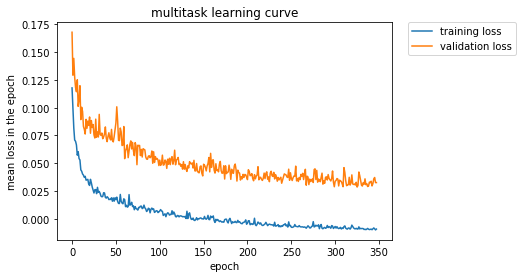

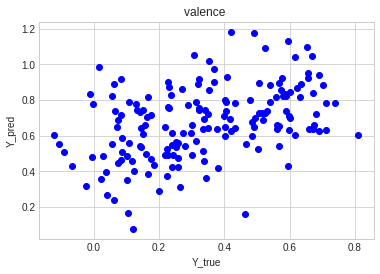

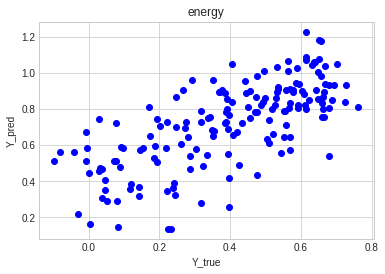

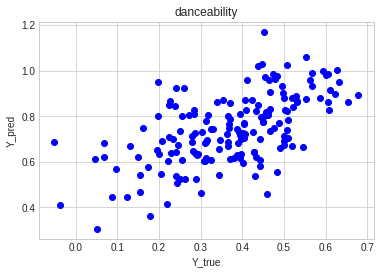

In [0]:
multi_set = SpectrogramDataset('../input/patreco3-multitask-affective-music/data/multitask_dataset/', train=True,
                                    class_mapping=None, max_length=-1,
                                    read_spec_fn=read_multi)
# Train and Test loaders
train_loader_multi, val_loader_multi, test_loader_multi = torch_train_val_test_split(multi_set, batch_train=32, batch_eval=32, val_size=.15, test_size=.15)


maxseqlen = train_CNN(train_loader_multi, val_loader_multi, "cnn_multi0", mels=128, dataset=multi_set)
scores=score_CNN(test_loader_multi, "cnn_multi0", mels=128, maxseqlen=maxseqlen)

In [0]:
print(scores)
print(np.mean(scores))

[0.29970287358730335, 0.647640704835297, 0.5328603074575999]
0.4934012952934001


## Kaggle Submit (team aponosiaponas)

Με τον παρακάτω κώδικα παρήχθη το predictions.csv.

In [0]:
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
import re

def torch_train_val_test_split(dataset, batch_train, batch_eval,
                            val_size=0, test_size=1, shuffle=False, seed=32):
    
    test_loader = DataLoader(dataset,
                            batch_size=1,
                            shuffle=False)
    
    return test_loader


def read_multi(spectrogram_file):
    '''
        spectrogram_file:  String, path file
    '''
    spectrogram = np.load(spectrogram_file)[0:128]
    return spectrogram.T


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])


# TODO: Comment on why padding is needed
class PaddingTransform(object):
    # Padding when needed
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        '''
            s: numpy array
        '''
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[:self.max_length] 

        if len(s) < self.max_length:
            # Padding in order to have same numpy shapes for all samples
            # since their timesteps dimension differs 
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1

        
class SpectrogramDataset(Dataset):
    
    def __init__(self, path, class_mapping=None, train=True, max_length=-1, read_spec_fn=read_multi, kind=-1):
        '''
            path:            String, the filepath of our data
            class_mapping:   Dict, the mapping of kinds of music
            train:           Boolean, (training or testing)
            max_length:      int
            read_spec_fn     function, the way that we would like to use the data
            kind:            int, 0: valence, 1: energy, 2: danceability
        '''
        
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        
        
        
        import glob
        file_list=glob.glob('../input/patreco3-multitask-affective-music/data/multitask_dataset/test/*.npy')
        flist=[]
        idds=[]
        for f in file_list:
            flist.append(f[-19:])   
            idds.append(f[-19:-15]) 
        self.files = flist
        self.ids=idds
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()

    
    def __getitem__(self, item):
        # Returns padded item, item label, l
        return self.zero_pad_and_stack(self.feats[item]), self.ids[item]

    
    def __len__(self):
        # Returns the number of dataset samples
        return len(self.files)

    

    
import csv


def kaggle_submit(test_loader, file_model, mels, maxseqlen):
          
    with open('predictions.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Id", "valence", "energy", "danceability"])
        file_model += ".pkl"
        model = torch.load(file_model)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # For batch normalization and dropout in testing
        model.eval()

        with torch.no_grad():
            y_pred1 = []
            y_true1 = []

            y_pred2 = []
            y_true2 = []

            y_pred3 = []
            y_true3 = []

            for i, (feats, ids) in enumerate(test_loader):
                feats = feats.view(-1, 1, maxseqlen, mels).to(device)

                predicted = model.forward(feats)
                for j in range(len(predicted)):
                    y_pred1.append(predicted[j][0].item())

                    y_pred2.append(predicted[j][1].item())

                    y_pred3.append(predicted[j][2].item())
                    writer.writerow([int(ids[0]), predicted[j][0].item(), predicted[j][1].item(), predicted[j][2].item()])

multi_set = SpectrogramDataset('../input/patreco3-multitask-affective-music/data/multitask_dataset/', train=False,
                                class_mapping=None, max_length=-1,
                                read_spec_fn=read_multi)
# # Train and Test loaders
test_loader_multi = torch_train_val_test_split(multi_set, batch_train=32, batch_eval=32)
maxseqlen=multi_set.max_length
kaggle_submit(test_loader_multi, "cnn_multi0", mels=128, maxseqlen=maxseqlen)
           
       
